## Installing and importing required libraries and modules

In [1]:
!pip install -U tensorflow-addons
!pip install scikeras
!pip install git+https://github.com/alessiogmonti/visualkeras

     |████████████████████████████████| 1.1 MB 5.3 MB/s 
  Cloning https://github.com/alessiogmonti/visualkeras to /tmp/pip-req-build-ght7f2c3
  Running command git clone -q https://github.com/alessiogmonti/visualkeras /tmp/pip-req-build-ght7f2c3
     |████████████████████████████████| 992 kB 5.4 MB/s 
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13033 sha256=b705bd4d5a58ed850052477691dda6a6f0328b508c5341a9e3c7bf18767ff5bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-wdwunb2q/wheels/8c/98/da/cd792cfaef8538e6921280cf1070358a4c09e7c50569f5bc69
Successfully built visualkeras


In [2]:
import os
import scipy.io
import numpy as np
import seaborn as sn
import tensorflow 
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import time
import random
import visualkeras
import skimage.transform # import image
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from keras.backend import clear_session
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score, auc, RocCurveDisplay
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from PIL import ImageFont
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier

### Setting Randomization to a constant value to get reproducible results


In [3]:
# Function sets all of the function calls to a constant random number
def reproducibility(seed = 1234):
  #fix random seed for reproducibility
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED']=str(seed)
  random.seed(seed)
  tf.compat.v1.set_random_seed(seed)
  tf.random.set_seed(seed)
  tf.keras.utils.set_random_seed(seed)  # sets seeds for base-python, numpy and tf
  tf.config.experimental.enable_op_determinism()
  
reproducibility() 

### Loading the data

In [4]:
!wget -q --show-progress https://github.com/Arshadoid/ITEC5920-BrainWaveClassification-/blob/main/Dataset/features_aa_440_0.mat?raw=true
!mv features_aa_440_0.mat\?raw\=true features_aa_440_0.mat
!wget -q --show-progress https://github.com/Arshadoid/ITEC5920-BrainWaveClassification-/blob/main/Dataset/features_al_440_0.mat?raw=true
!mv features_al_440_0.mat\?raw\=true features_al_440_0.mat
!wget -q --show-progress https://github.com/Arshadoid/ITEC5920-BrainWaveClassification-/blob/main/Dataset/features_av_440_0.mat?raw=true
!mv features_av_440_0.mat\?raw\=true features_av_440_0.mat
!wget -q --show-progress https://github.com/Arshadoid/ITEC5920-BrainWaveClassification-/blob/main/Dataset/features_aw_440_0.mat?raw=true
!mv features_aw_440_0.mat\?raw\=true features_aw_440_0.mat
!wget -q --show-progress https://github.com/Arshadoid/ITEC5920-BrainWaveClassification-/blob/main/Dataset/features_ay_440_0.mat?raw=true
!mv features_ay_440_0.mat\?raw\=true features_ay_440_0.mat

!wget -q --show-progress https://github.com/Arshadoid/ITEC5920-BrainWaveClassification-/blob/main/Dataset/true_labels_aa.mat?raw=true
!mv true_labels_aa.mat\?raw\=true true_labels_aa.mat
!wget -q --show-progress https://github.com/Arshadoid/ITEC5920-BrainWaveClassification-/blob/main/Dataset/true_labels_al.mat?raw=true
!mv true_labels_al.mat\?raw\=true true_labels_al.mat
!wget -q --show-progress https://github.com/Arshadoid/ITEC5920-BrainWaveClassification-/blob/main/Dataset/true_labels_av.mat?raw=true
!mv true_labels_av.mat\?raw\=true true_labels_av.mat
!wget -q --show-progress https://github.com/Arshadoid/ITEC5920-BrainWaveClassification-/blob/main/Dataset/true_labels_aw.mat?raw=true
!mv true_labels_aw.mat\?raw\=true true_labels_aw.mat
!wget -q --show-progress https://github.com/Arshadoid/ITEC5920-BrainWaveClassification-/blob/main/Dataset/true_labels_ay.mat?raw=true
!mv true_labels_ay.mat\?raw\=true true_labels_ay.mat

features_aa_440_0.m 100%[===================>]   2.50M  --.-KB/s    in 0.07s   
features_al_440_0.m 100%[===================>]   2.50M  --.-KB/s    in 0.07s   
features_av_440_0.m 100%[===================>]   2.50M  --.-KB/s    in 0.06s   
features_aw_440_0.m 100%[===================>]   2.50M  --.-KB/s    in 0.06s   
features_ay_440_0.m 100%[===================>]   2.50M  --.-KB/s    in 0.06s   
true_labels_aa.mat? 100%[===================>]     760  --.-KB/s    in 0s      
true_labels_al.mat? 100%[===================>]     648  --.-KB/s    in 0s      
true_labels_av.mat? 100%[===================>]     928  --.-KB/s    in 0s      
true_labels_aw.mat? 100%[===================>]     984  --.-KB/s    in 0s      
true_labels_ay.mat? 100%[===================>]   1.02K  --.-KB/s    in 0s      


In [5]:
# loading the data 
mat_features_aa=scipy.io.loadmat('features_aa_440_0.mat')
mat_labels_aa=scipy.io.loadmat('true_labels_aa.mat')
mat_features_al=scipy.io.loadmat('features_al_440_0.mat')
mat_labels_al=scipy.io.loadmat('true_labels_al.mat')
mat_features_av=scipy.io.loadmat('features_av_440_0.mat')
mat_labels_av=scipy.io.loadmat('true_labels_av.mat')
mat_features_aw=scipy.io.loadmat('features_aw_440_0.mat')
mat_labels_aw=scipy.io.loadmat('true_labels_aw.mat')
mat_features_ay=scipy.io.loadmat('features_ay_440_0.mat')
mat_labels_ay=scipy.io.loadmat('true_labels_ay.mat')

# selecting the related columns
mat_features_aa = mat_features_aa['features']
mat_labels_aa = mat_labels_aa['true_y']
mat_features_al = mat_features_al['features']
mat_labels_al = mat_labels_al['true_y']
mat_features_av = mat_features_av['features']
mat_labels_av = mat_labels_av['true_y']
mat_features_aw = mat_features_aw['features']
mat_labels_aw = mat_labels_aw['true_y']
mat_features_ay = mat_features_ay['features']
mat_labels_ay = mat_labels_ay['true_y']

In [6]:
# list of subjects features and labels
aa = ['aa', mat_features_aa, mat_labels_aa]
al = ['al',mat_features_al, mat_labels_al]
av = ['av',mat_features_av, mat_labels_av]
aw = ['aw',mat_features_aw, mat_labels_aw]
ay = ['ay',mat_features_aw, mat_labels_aw]
features_labels = [aa, al, av, aw, ay]

### Preparing the data for training and testing

#### Transposing the feature arrays of each subject from (6,201,280) to (280,201,6)

In [7]:
for subject in features_labels:
  X_all = np.transpose(subject[1], (2, 1, 0))
  subject.append(X_all)
  print(f'Shape of X_all_{subject[0]}:',X_all.shape)

Shape of X_all_aa: (280, 201, 6)
Shape of X_all_al: (280, 201, 6)
Shape of X_all_av: (280, 201, 6)
Shape of X_all_aw: (280, 201, 6)
Shape of X_all_ay: (280, 201, 6)


#### Splitting dataset into training/test with required split ratio with stratification

In [8]:
from sklearn.model_selection import train_test_split

# defining the ratios between train and test sets as specified in the project
aa_data = ['aa',0.4]   #112/280 
al_data = ['al',0.2]   #56/280
av_data = ['av',0.7]   #196/200
aw_data = ['aw',0.8]   #224/280
ay_data = ['ay',0.9]   #252/280

data = [aa_data, al_data, av_data, aw_data, ay_data]
i = 0 
for subject in features_labels: 
  
  #splitting the data with the specified ratio
  X_train, X_test, y_train, y_test = train_test_split(
    subject[3], subject[2].ravel(),test_size=data[i][1], 
    random_state=42,shuffle=True, stratify=subject[2].ravel())
  
  data[i].append(X_train)
  data[i].append(X_test)

  # converting the labels to 0,1 instead of 1,2
  y_train = np.where(y_train > 1, 1, 0)  
  y_test = np.where(y_test > 1, 1, 0)
  data[i].append(y_train)
  data[i].append(y_test)

  print(f'\nTraining and test split for Subject {subject[0]}:')
  print(f'  X_train_{subject[0]}:',X_train.shape, 
        f'\n  X_test_{subject[0]}:',X_test.shape,
        f'\n  y_train_{subject[0]}:',y_train.shape,
        f'\n  y_test_{subject[0]}:', y_test.shape)
  i+=1


Training and test split for Subject aa:
  X_train_aa: (168, 201, 6) 
  X_test_aa: (112, 201, 6) 
  y_train_aa: (168,) 
  y_test_aa: (112,)

Training and test split for Subject al:
  X_train_al: (224, 201, 6) 
  X_test_al: (56, 201, 6) 
  y_train_al: (224,) 
  y_test_al: (56,)

Training and test split for Subject av:
  X_train_av: (84, 201, 6) 
  X_test_av: (196, 201, 6) 
  y_train_av: (84,) 
  y_test_av: (196,)

Training and test split for Subject aw:
  X_train_aw: (56, 201, 6) 
  X_test_aw: (224, 201, 6) 
  y_train_aw: (56,) 
  y_test_aw: (224,)

Training and test split for Subject ay:
  X_train_ay: (28, 201, 6) 
  X_test_ay: (252, 201, 6) 
  y_train_ay: (28,) 
  y_test_ay: (252,)


In [9]:
X_test_aa = data[0][3]
X_test_aa = X_test_aa.reshape(112,201*6)
y_test_aa = data[0][5]

X_test_al = data[1][3]
X_test_al = X_test_al.reshape(56,201*6)
y_test_al = data[1][5]

X_test_av = data[2][3]
X_test_av = X_test_av.reshape(196,201*6)
y_test_av = data[2][5]

X_test_aw = data[3][3]
X_test_aw = X_test_aw.reshape(224,201*6)
y_test_aw = data[3][5]

X_test_ay = data[4][3]
X_test_ay = X_test_ay.reshape(252,201*6)
y_test_ay = data[4][5]

#### Creating X_train and y_train from the selected samples 

In [10]:
#combining all train subjects into one total features array
total_train_features = np.array([])
for sample in data:

  #adding subject features to the total array
  total_train_features = np.append(total_train_features,sample[2])

#reshaping the total features to 168+224+84+56+28 = 560, each with 201 x 6 
X_train = np.reshape(total_train_features, (560, 201, 6))
print('X_train shape:',X_train.shape)

#combining all train labels into one array
total_labels = np.array([])
for label in data:
  #adding subject features to the total array
  total_labels = np.append(total_labels, label[4])
  
y_train = total_labels.astype(int)
print('y_train shape:',y_train.shape)

X_train shape: (560, 201, 6)
y_train shape: (560,)


### Checking for over sampling requirement

In [11]:
#checking for oversampling
neg, pos = np.bincount(y_train)
total = neg + pos
print('\n Train data:\n    Train Shape: {}\n    Total: {}\n    Positive: {} ({:.2f}% of total)'.format(
    X_train.shape, total, pos, 100 * pos / total))


 Train data:
    Train Shape: (560, 201, 6)
    Total: 560
    Positive: 280 (50.00% of total)


No need for over sampling as 0 and 1 samples ratio is 1:1

### Augmentation (adding noise and horizontal flip) of Training set


In [12]:
reproducibility() # resetting randomizers

#lets add 1000 more samples to the dataset
X_train_aug = X_train
y_train_aug = y_train

for i in range(1000):
  x = np.random.uniform(0, 1)   # to determine what type of augmentation
  y = np.random.randint(0, 559) # to randomly select a sample 

  if x < 0.50: # flip the sample left to right 
    img = X_train[y].astype('float32')
    output = np.flip(img, 0) 

  else: # adding gaussian noise to the sample
    img = X_train[y].astype('float32')
    noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=1.0, dtype=tf.float32)
    output = tf.add(img, noise)
  
  X_train_aug = np.append(X_train_aug, output) # appending the flipped to X_train_aug
  y_train_aug = np.append(y_train_aug, y_train[y]) # appending the label to y_train_aug
      
X_train_aug = np.reshape(X_train_aug,(1560,201,6))

### Preprocessing of augmented training set

In [13]:
scaler = StandardScaler()
X_train_aug_scaled = scaler.fit_transform(X_train_aug.reshape(-1, X_train_aug.shape[-1])).reshape(X_train_aug.shape)

# OneHotEncoding y
y_train_aug_OHE = np_utils.to_categorical(y_train_aug)

# Reshaping Feature input data to make it suitable for CNN
X_train_aug_scaled_reshaped=X_train_aug_scaled.reshape((X_train_aug_scaled.shape[0],201,6,1))
#run_CNN_Model_NoSKF(X_train_aug_scaled_reshaped, y_train_aug_OHE)

### Funciton to plot Training Accuracy and Loss 

In [26]:
def plotPerformance(history):

  loss_values = history.history['loss']
  accuracy = history.history['accuracy']
    
  epochs = range(1, len(loss_values) + 1)
 
  plt.plot(epochs, accuracy, 'g', label='Training Accuracy')
  plt.plot(epochs, loss_values, 'b', label='Training Loss')
  plt.title('Training Accuracy and Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy/Loss')
  plt.legend()
  plt.show() 


## MLP model

In [28]:
# Defining MLP model structure
def MLP_model():
  clear_session()
  model=None
  model = Sequential() 
  model.add(Flatten(input_shape=[201*6]))
  for i in range(20):
    model.add(Dense(units = 100, activation = 'relu', kernel_initializer = 'he_normal'))
  # adding output layer
  model.add(Dense(2, activation="sigmoid"))
  #compiling with adam obtimizer
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

### MLP model Visualization

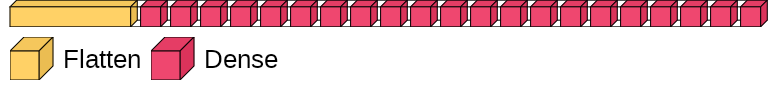

In [29]:
model = MLP_model()
font = ImageFont.truetype("LiberationSans-Regular.ttf", 26) 
visualkeras.layered_view(model, to_file='MLPmodel.png', legend=True, font=font)

#### Implementing GridSearchCV to find the best hyperparameters

In [ ]:
# clearing previous sessions before moving forward 
clear_session()
# Parameters to be used in GridSearch
batch_size = [5, 10, 20, 40, 60, 80, 100]
epochs = [10, 30, 50, 100]

# Creating grid parameter dictionary to use in GridSearch
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Defining KerasClassfier to be wrapped around MLP model
MLP_model_for_grid = KerasClassifier(build_fn=MLP_model(), verbose=0)
# Defining GridSearch with 5-fold cross validation for 
MLP_grid = GridSearchCV(estimator=MLP_model_for_grid, param_grid=param_grid, 
                        n_jobs=-1, cv=5)
MLP_grid_result = MLP_grid.fit(X_train_aug_, y_train_aug_OHE)


# summarize results
print("Best: %f using %s" % (MLP_grid_result.best_score_, MLP_grid_result.best_params_))
means = MLP_grid_result.cv_results_['mean_test_score']
stds = MLP_grid_result.cv_results_['std_test_score']
params = MLP_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

INFO:tensorflow:Assets written to: ram:///tmp/tmpw6ji_c92/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpb500qr1i/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp02hop8i3/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp2lfuyvwj/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpkqpxwroh/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp6dd1xqly/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmphqhp8tk4/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp3fw1dfcs/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpg6x_6h40/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp8lkmoeaz/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpfa19er52/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmphmd1d7mk/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpvqjm1f5_/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp53iu19xn/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpu2n0ti6r/assets
INFO:tensorflow:Assets wr

#### running MLP with best parameters

In [30]:
def run_MLP_Model_Final(train_X, train_y, x_test_list):
  clear_session()
  start_time = time.time()

  # Hyperparameters
  batch_size = 60
  no_epochs = 30

  MLPmodel=None
  MLPmodel=MLP_model()
  
  # Defining Early stopping and Checkpoint
  earlyStop = EarlyStopping(monitor='loss', 
                                mode = 'min',
                              patience=10) 
  
  # Fit data to model
  history = MLPmodel.fit(train_X, train_y,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=1,
                callbacks=earlyStop)
  time_1_1=time.time() - start_time
  print("--- %s seconds ---" % (time.time() - start_time))

  y_prob_list = []
  for test in x_test_list:
    y_prob = MLPmodel.predict(test[0])
    y_prob_list.append(y_prob)
  
  #Plotting model training performance
  plotPerformance(history)
  return MLPmodel, y_prob_list

#### Creating Test Set list with test set and labels for each subject. And running MLP model 

Epoch 1/30
26/26 [==============================] - 2s 7ms/step - loss: 0.5055 - accuracy: 0.7968
Epoch 2/30
26/26 [==============================] - 0s 8ms/step - loss: 0.1341 - accuracy: 0.9545
Epoch 3/30
26/26 [==============================] - 0s 7ms/step - loss: 0.0510 - accuracy: 0.9878
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 0.0896 - accuracy: 0.9795
Epoch 5/30
26/26 [==============================] - 0s 7ms/step - loss: 0.0456 - accuracy: 0.9865
Epoch 6/30
26/26 [==============================] - 0s 7ms/step - loss: 0.0297 - accuracy: 0.9936
Epoch 7/30
26/26 [==============================] - 0s 8ms/step - loss: 0.0239 - accuracy: 0.9929
Epoch 8/30
26/26 [==============================] - 0s 7ms/step - loss: 0.1737 - accuracy: 0.9827
Epoch 9/30
26/26 [==============================] - 0s 7ms/step - loss: 0.0727 - accuracy: 0.9904
Epoch 10/30
26/26 [==============================] - 0s 7ms/step - loss: 0.0264 - accuracy: 0.9923
Epoch 11/30
26/26 [

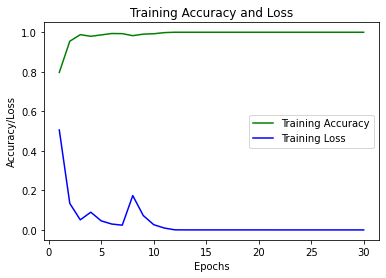

In [31]:
x_test_list = [[X_test_aa, y_test_aa], [X_test_al, y_test_al],[X_test_av, y_test_av], 
               [X_test_aw, y_test_aw],[X_test_ay, y_test_ay]]

X_train_aug_ = X_train_aug.reshape(X_train_aug.shape[0], 201*6)
y_train_OHE = np_utils.to_categorical(y_train)
reproducibility()
MLP_model, MLP_pred_list = run_MLP_Model_Final(X_train_aug_, y_train_aug_OHE, x_test_list)

##Transformer model

In [32]:
# Defining parameters 
num_classes = 2
input_shape = (201, 2, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [33]:
# Defining function to implement dropouts to the given units with given rate
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [34]:
# Creating Patches class for the layers
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [38]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [35]:
# Defining ViT (transformer) class
def create_vit_classifier(data_augmentation):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    optimizer = tf.optimizers.Adam()
    # optimizer = tfa.optimizers.AdamW(
    #     learning_rate=learning_rate, weight_decay=weight_decay
    # )
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
        ],)
    return model

#### Grid search for best ViT parameters

In [ ]:
# Clearing previous sessions and resetting randomizers before moving forward 
clear_session()
reproducibility()
# Parameters to be used in GridSearch
# learning_rate = [0.0001,0.001]
# weight_decay = [0.0005,0.0001]
batch_size = [100, 256]
epochs = [50, 100]

# Creating grid parameter dictionary to use in GridSearch
# param_grid = dict(batch_size=batch_size, num_epochs=epochs, learning_rate =learning_rate, weight_decay = weight_decay)
param_grid = dict(batch_size=batch_size, epochs=epochs)
data_augmentation = Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
    ],
    name="data_augmentation",
)
x_train = X_train_aug.reshape(X_train_aug.shape[0], 201*6)
x_train_ = x_train.reshape(x_train.shape[0], 201, 2 , 3)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train_)

# Defining KerasClassfier to be wrapped around ViT model
ViT_model_for_grid = KerasClassifier(build_fn=create_vit_classifier(data_augmentation), verbose=1)
# Defining GridSearch with 5-fold cross validation for 
ViT_grid = GridSearchCV(estimator=ViT_model_for_grid, param_grid=param_grid, 
                        cv=5)
# print(ViT_model_for_grid.get_params().keys())
ViT_grid_result = ViT_grid.fit(x_train_, y_train_aug_OHE)


# summarize results
print("Best: %f using %s" % (ViT_grid_result.best_score_, ViT_grid_result.best_params_))
means = ViT_grid_result.cv_results_['mean_test_score']
stds = ViT_grid_result.cv_results_['std_test_score']
params = ViT_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Transformer run with best parameters

In [36]:
def run_ViT(x_train, y_train, x_test_list):
    # optimizer = tfa.optimizers.AdamW(
    #     learning_rate=0.001, weight_decay=weight_decay
    # )
    x_train_ = x_train.reshape(x_train.shape[0], 201, 2 , 3)
    data_augmentation = Sequential(
        [
            layers.Normalization(),
            layers.Resizing(image_size, image_size),
        ],
        name="data_augmentation",
    )
    # Compute the mean and the variance of the training data for normalization.
    data_augmentation.layers[0].adapt(x_train_)

    model = create_vit_classifier(data_augmentation)

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    earlyStop = EarlyStopping(monitor='val_loss', 
                                mode = 'min',
                              patience=20) 
    history = model.fit(
        x=x_train_,
        y=y_train,
        batch_size=100,
        epochs=50,
        validation_split=0.1,
        callbacks=[earlyStop, checkpoint_callback],
    )

    y_prob_list = []
    for test in x_test_list:
      x_test_ = test[0].reshape(test[0].shape[0], 201, 2 , 3)
      y_prob = model.predict(x_test_)
      prediction = tf.nn.sigmoid(y_prob)
      y_prob_list.append(prediction)
    
    # Plotting training performance
    plotPerformance(history)

    return model, y_prob_list




### Testing ViT(Transformer Model)

Epoch 1/50
15/15 [==============================] - 14s 434ms/step - loss: 2.1851 - accuracy: 0.7756 - val_loss: 0.4913 - val_accuracy: 0.9295
Epoch 2/50
15/15 [==============================] - 4s 246ms/step - loss: 0.3722 - accuracy: 0.9437 - val_loss: 0.2009 - val_accuracy: 0.9679
Epoch 3/50
15/15 [==============================] - 4s 244ms/step - loss: 0.7054 - accuracy: 0.9238 - val_loss: 0.1404 - val_accuracy: 0.9808
Epoch 4/50
15/15 [==============================] - 3s 192ms/step - loss: 0.2738 - accuracy: 0.9665 - val_loss: 0.1924 - val_accuracy: 0.9551
Epoch 5/50
15/15 [==============================] - 3s 192ms/step - loss: 0.2184 - accuracy: 0.9658 - val_loss: 0.1611 - val_accuracy: 0.9744
Epoch 6/50
15/15 [==============================] - 4s 242ms/step - loss: 0.1523 - accuracy: 0.9779 - val_loss: 0.2107 - val_accuracy: 0.9872
Epoch 7/50
15/15 [==============================] - 3s 191ms/step - loss: 0.0932 - accuracy: 0.9815 - val_loss: 0.1052 - val_accuracy: 0.9872
Epoch

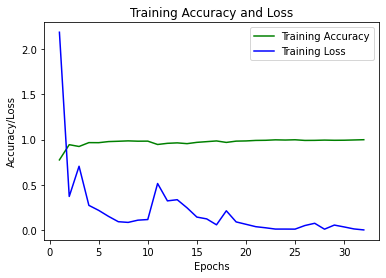

In [39]:
x_test_list = [[X_test_aa, y_test_aa], [X_test_al, y_test_al],[X_test_av, y_test_av], 
               [X_test_aw, y_test_aw],[X_test_ay, y_test_ay]]
X_train_aug_ = X_train_aug.reshape(X_train_aug.shape[0], 201*6)
reproducibility()
vit_classifier, vit_pred_list = run_ViT(X_train_aug_, y_train_aug_OHE, x_test_list)

## CNN model

### Data preprocessing for CNN

In [40]:
reproducibility()  #resetting randomizers
# Data Preprocessing function for CNN
def CNN_prep(X, y, test_list=[], cnn=True):
  scaler = StandardScaler()

  def scaling_reshaping(X, cnn):
    X = np.reshape(X, (len(X), 201, 6))
    X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    if cnn==True:
      # Reshaping Feature input data to make it suitable for CNN
      X_scaled=X_scaled.reshape((X_scaled.shape[0],201,6,1))  
    return X_scaled  
  X_scaled_reshaped=scaling_reshaping(X,cnn)  

  # OneHotEncoding y
  y_OHE = np_utils.to_categorical(y)
  
  new_test_list = []
  for d in test_list:
    new_test_list.append(scaling_reshaping(d,cnn))
  
  return X_scaled_reshaped, y_OHE, new_test_list

### Defining CNN model

In [41]:
# Structured CNN Model
def cnnModel():
  # Clearing session and resetting randomizers
  clear_session()
  reproducibility()
  # Building the model
  model=None
  # defining Sequantial model
  model = Sequential()
  # first hidden layer
  model.add(Conv2D(filters= 32, kernel_size=(3,3), activation='relu', input_shape=(201,6,1)))
  # second hidden layer
  model.add(Conv2D(filters= 64, kernel_size=(1,1), activation='relu'))
  # third hidden layer
  model.add(Conv2D(filters= 128, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(1,1)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  # third hidden layer
  model.add(Dense(128, activation ='relu', name = 'middle_layer'))
  model.add(Dropout(0.5,name='middle_layer_2'))
  model.add(Dense(64, activation ='relu', name='middle_layer_3'))
  model.add(Dropout(0.5))
  # output layer
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

### Visualizing CNN model

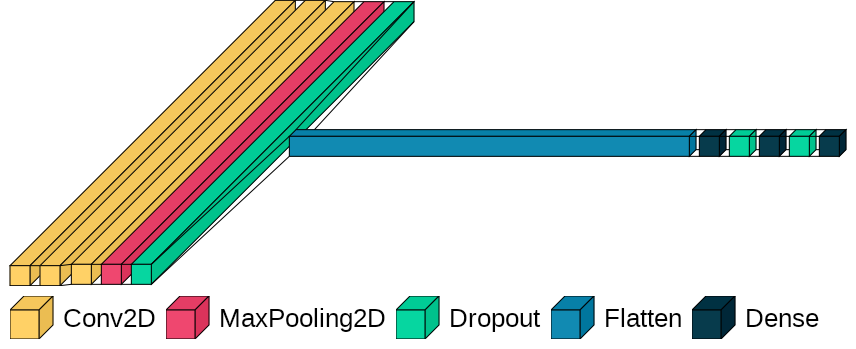

In [42]:
model = cnnModel()
font = ImageFont.truetype("LiberationSans-Regular.ttf", 26) 
visualkeras.layered_view(model, to_file='CNNmodel.png', legend=True, font=font)

### Implementing GridSearchCV on CNN  model to find the best hyperparameters  

In [ ]:
# clearing previous sessions before moving forward 
clear_session()
reproducibility()
# Parameters to be used in GridSearch
batch_size = [5, 20, 40, 60]
epochs = [30, 50, 80, 100]

# Creating grid parameter dictionary to use in GridSearch
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Defining KerasClassfier to be wrapped around MLP model
CNN_model_for_grid = KerasClassifier(build_fn=cnnModel(), verbose=1)
# Defining GridSearch with 5-fold cross validation for 
CNN_grid = GridSearchCV(estimator=CNN_model_for_grid, param_grid=param_grid, cv=5)
CNN_grid_result = CNN_grid.fit(X_train_aug_scaled_reshaped, y_train_aug_OHE)


# summarize results
print("Best: %f using %s" % (CNN_grid_result.best_score_, CNN_grid_result.best_params_))
means = CNN_grid_result.cv_results_['mean_test_score']
stds = CNN_grid_result.cv_results_['std_test_score']
params = CNN_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

INFO:tensorflow:Assets written to: ram:///tmp/tmpxwnyvh3u/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp4cz6decg/assets
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 6s 12ms/step - loss: 0.3164 - accuracy: 0.8982
Epoch 2/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1220 - accuracy: 0.9631
Epoch 3/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1254 - accuracy: 0.9567
Epoch 4/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1177 - accuracy: 0.9671
Epoch 5/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0901 - accuracy: 0.9808
Epoch 6/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1730 - accuracy: 0.9688
Epoch 7/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0708 - accuracy: 0.9752
Epoch 8/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1103 - accuracy: 0.9704
Epoch 9/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0623 - accuracy: 0.9840
Epoch 10/30
250/250 [==============================] - 4s 14ms/step - loss: 0.0308 - accuracy: 0.9888


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 5s 15ms/step - loss: 0.2449 - accuracy: 0.9159
Epoch 2/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1551 - accuracy: 0.9487
Epoch 3/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0754 - accuracy: 0.9728
Epoch 4/30
250/250 [==============================] - 3s 11ms/step - loss: 0.4099 - accuracy: 0.9495
Epoch 5/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0924 - accuracy: 0.9720
Epoch 6/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0898 - accuracy: 0.9696
Epoch 7/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1083 - accuracy: 0.9768
Epoch 8/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1628 - accuracy: 0.9647
Epoch 9/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0893 - accuracy: 0.9736
Epoch 10/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0746 - accuracy: 0.9800


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 12ms/step - loss: 0.2646 - accuracy: 0.9103
Epoch 2/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1754 - accuracy: 0.9503
Epoch 3/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1141 - accuracy: 0.9631
Epoch 4/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1110 - accuracy: 0.9623
Epoch 5/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0988 - accuracy: 0.9704
Epoch 6/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1007 - accuracy: 0.9728
Epoch 7/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0995 - accuracy: 0.9704
Epoch 8/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1616 - accuracy: 0.9720
Epoch 9/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0589 - accuracy: 0.9848
Epoch 10/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0457 - accuracy: 0.9888


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 12ms/step - loss: 0.2873 - accuracy: 0.9046
Epoch 2/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1866 - accuracy: 0.9399
Epoch 3/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1288 - accuracy: 0.9639
Epoch 4/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1299 - accuracy: 0.9591
Epoch 5/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0526 - accuracy: 0.9840
Epoch 6/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0713 - accuracy: 0.9752
Epoch 7/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1288 - accuracy: 0.9671
Epoch 8/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0991 - accuracy: 0.9704
Epoch 9/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0528 - accuracy: 0.9832
Epoch 10/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0590 - accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 11ms/step - loss: 0.2701 - accuracy: 0.9038
Epoch 2/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1325 - accuracy: 0.9559
Epoch 3/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1545 - accuracy: 0.9567
Epoch 4/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1270 - accuracy: 0.9631
Epoch 5/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0748 - accuracy: 0.9720
Epoch 6/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1029 - accuracy: 0.9679
Epoch 7/30
250/250 [==============================] - 3s 11ms/step - loss: 0.1617 - accuracy: 0.9599
Epoch 8/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0444 - accuracy: 0.9816
Epoch 9/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0767 - accuracy: 0.9776
Epoch 10/30
250/250 [==============================] - 3s 11ms/step - loss: 0.0566 - accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 6s 18ms/step - loss: 0.3164 - accuracy: 0.8982
Epoch 2/50
250/250 [==============================] - 4s 17ms/step - loss: 0.1220 - accuracy: 0.9631
Epoch 3/50
250/250 [==============================] - 4s 15ms/step - loss: 0.1254 - accuracy: 0.9567
Epoch 4/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1177 - accuracy: 0.9671
Epoch 5/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0901 - accuracy: 0.9808
Epoch 6/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1730 - accuracy: 0.9688
Epoch 7/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0708 - accuracy: 0.9752
Epoch 8/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1103 - accuracy: 0.9704
Epoch 9/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0623 - accuracy: 0.9840
Epoch 10/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0308 - accuracy: 0.9888


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 11ms/step - loss: 0.2449 - accuracy: 0.9159
Epoch 2/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1551 - accuracy: 0.9487
Epoch 3/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0754 - accuracy: 0.9728
Epoch 4/50
250/250 [==============================] - 3s 11ms/step - loss: 0.4099 - accuracy: 0.9495
Epoch 5/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0924 - accuracy: 0.9720
Epoch 6/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0898 - accuracy: 0.9696
Epoch 7/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1083 - accuracy: 0.9768
Epoch 8/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1628 - accuracy: 0.9647
Epoch 9/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0893 - accuracy: 0.9736
Epoch 10/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0746 - accuracy: 0.9800


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 12ms/step - loss: 0.2646 - accuracy: 0.9103
Epoch 2/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1754 - accuracy: 0.9503
Epoch 3/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1141 - accuracy: 0.9631
Epoch 4/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1110 - accuracy: 0.9623
Epoch 5/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0988 - accuracy: 0.9704
Epoch 6/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1007 - accuracy: 0.9728
Epoch 7/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0995 - accuracy: 0.9704
Epoch 8/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1616 - accuracy: 0.9720
Epoch 9/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0589 - accuracy: 0.9848
Epoch 10/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0457 - accuracy: 0.9888


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 12ms/step - loss: 0.2873 - accuracy: 0.9046
Epoch 2/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1866 - accuracy: 0.9399
Epoch 3/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1288 - accuracy: 0.9639
Epoch 4/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1299 - accuracy: 0.9591
Epoch 5/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0526 - accuracy: 0.9840
Epoch 6/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0713 - accuracy: 0.9752
Epoch 7/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1288 - accuracy: 0.9671
Epoch 8/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0991 - accuracy: 0.9704
Epoch 9/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0528 - accuracy: 0.9832
Epoch 10/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0590 - accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 11ms/step - loss: 0.2701 - accuracy: 0.9038
Epoch 2/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1325 - accuracy: 0.9559
Epoch 3/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1545 - accuracy: 0.9567
Epoch 4/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1270 - accuracy: 0.9631
Epoch 5/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0748 - accuracy: 0.9720
Epoch 6/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1029 - accuracy: 0.9679
Epoch 7/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1617 - accuracy: 0.9599
Epoch 8/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0444 - accuracy: 0.9816
Epoch 9/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0767 - accuracy: 0.9776
Epoch 10/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0566 - accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 12ms/step - loss: 0.3164 - accuracy: 0.8982
Epoch 2/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1220 - accuracy: 0.9631
Epoch 3/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1254 - accuracy: 0.9567
Epoch 4/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1177 - accuracy: 0.9671
Epoch 5/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0901 - accuracy: 0.9808
Epoch 6/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1730 - accuracy: 0.9688
Epoch 7/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0708 - accuracy: 0.9752
Epoch 8/80
250/250 [==============================] - 3s 12ms/step - loss: 0.1103 - accuracy: 0.9704
Epoch 9/80
250/250 [==============================] - 3s 14ms/step - loss: 0.0623 - accuracy: 0.9840
Epoch 10/80
250/250 [==============================] - 4s 15ms/step - loss: 0.0308 - accuracy: 0.9888


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 12ms/step - loss: 0.2449 - accuracy: 0.9159
Epoch 2/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1551 - accuracy: 0.9487
Epoch 3/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0754 - accuracy: 0.9728
Epoch 4/80
250/250 [==============================] - 3s 11ms/step - loss: 0.4099 - accuracy: 0.9495
Epoch 5/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0924 - accuracy: 0.9720
Epoch 6/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0898 - accuracy: 0.9696
Epoch 7/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1083 - accuracy: 0.9768
Epoch 8/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1628 - accuracy: 0.9647
Epoch 9/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0893 - accuracy: 0.9736
Epoch 10/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0746 - accuracy: 0.9800


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 11ms/step - loss: 0.2646 - accuracy: 0.9103
Epoch 2/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1754 - accuracy: 0.9503
Epoch 3/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1141 - accuracy: 0.9631
Epoch 4/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1110 - accuracy: 0.9623
Epoch 5/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0988 - accuracy: 0.9704
Epoch 6/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1007 - accuracy: 0.9728
Epoch 7/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0995 - accuracy: 0.9704
Epoch 8/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1616 - accuracy: 0.9720
Epoch 9/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0589 - accuracy: 0.9848
Epoch 10/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0457 - accuracy: 0.9888


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 12ms/step - loss: 0.2873 - accuracy: 0.9046
Epoch 2/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1866 - accuracy: 0.9399
Epoch 3/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1288 - accuracy: 0.9639
Epoch 4/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1299 - accuracy: 0.9591
Epoch 5/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0526 - accuracy: 0.9840
Epoch 6/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0713 - accuracy: 0.9752
Epoch 7/80
250/250 [==============================] - 3s 11ms/step - loss: 0.1288 - accuracy: 0.9671
Epoch 8/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0991 - accuracy: 0.9704
Epoch 9/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0528 - accuracy: 0.9832
Epoch 10/80
250/250 [==============================] - 3s 11ms/step - loss: 0.0590 - accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 13ms/step - loss: 0.2701 - accuracy: 0.9038
Epoch 2/80
250/250 [==============================] - 3s 12ms/step - loss: 0.1325 - accuracy: 0.9559
Epoch 3/80
250/250 [==============================] - 3s 12ms/step - loss: 0.1545 - accuracy: 0.9567
Epoch 4/80
250/250 [==============================] - 3s 12ms/step - loss: 0.1270 - accuracy: 0.9631
Epoch 5/80
250/250 [==============================] - 3s 12ms/step - loss: 0.0748 - accuracy: 0.9720
Epoch 6/80
250/250 [==============================] - 3s 12ms/step - loss: 0.1029 - accuracy: 0.9679
Epoch 7/80
250/250 [==============================] - 3s 13ms/step - loss: 0.1617 - accuracy: 0.9599
Epoch 8/80
250/250 [==============================] - 3s 12ms/step - loss: 0.0444 - accuracy: 0.9816
Epoch 9/80
250/250 [==============================] - 3s 12ms/step - loss: 0.0767 - accuracy: 0.9776
Epoch 10/80
250/250 [==============================] - 3s 13ms/step - loss: 0.0566 - accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 13ms/step - loss: 0.3164 - accuracy: 0.8982
Epoch 2/100
250/250 [==============================] - 3s 12ms/step - loss: 0.1220 - accuracy: 0.9631
Epoch 3/100
250/250 [==============================] - 3s 13ms/step - loss: 0.1254 - accuracy: 0.9567
Epoch 4/100
250/250 [==============================] - 3s 13ms/step - loss: 0.1177 - accuracy: 0.9671
Epoch 5/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0901 - accuracy: 0.9808
Epoch 6/100
250/250 [==============================] - 3s 13ms/step - loss: 0.1730 - accuracy: 0.9688
Epoch 7/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0708 - accuracy: 0.9752
Epoch 8/100
250/250 [==============================] - 3s 12ms/step - loss: 0.1103 - accuracy: 0.9704
Epoch 9/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0623 - accuracy: 0.9840
Epoch 10/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0308 - accuracy

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 14ms/step - loss: 0.2449 - accuracy: 0.9159
Epoch 2/100
250/250 [==============================] - 3s 13ms/step - loss: 0.1551 - accuracy: 0.9487
Epoch 3/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0754 - accuracy: 0.9728
Epoch 4/100
250/250 [==============================] - 3s 12ms/step - loss: 0.4099 - accuracy: 0.9495
Epoch 5/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0924 - accuracy: 0.9720
Epoch 6/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0898 - accuracy: 0.9696
Epoch 7/100
250/250 [==============================] - 3s 12ms/step - loss: 0.1083 - accuracy: 0.9768
Epoch 8/100
250/250 [==============================] - 3s 12ms/step - loss: 0.1628 - accuracy: 0.9647
Epoch 9/100
250/250 [==============================] - 3s 11ms/step - loss: 0.0893 - accuracy: 0.9736
Epoch 10/100
250/250 [==============================] - 3s 11ms/step - loss: 0.0746 - accuracy

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 12ms/step - loss: 0.2646 - accuracy: 0.9103
Epoch 2/100
250/250 [==============================] - 3s 12ms/step - loss: 0.1754 - accuracy: 0.9503
Epoch 3/100
250/250 [==============================] - 3s 12ms/step - loss: 0.1141 - accuracy: 0.9631
Epoch 4/100
250/250 [==============================] - 3s 12ms/step - loss: 0.1110 - accuracy: 0.9623
Epoch 5/100
250/250 [==============================] - 3s 11ms/step - loss: 0.0988 - accuracy: 0.9704
Epoch 6/100
250/250 [==============================] - 3s 11ms/step - loss: 0.1007 - accuracy: 0.9728
Epoch 7/100
250/250 [==============================] - 3s 11ms/step - loss: 0.0995 - accuracy: 0.9704
Epoch 8/100
250/250 [==============================] - 3s 12ms/step - loss: 0.1616 - accuracy: 0.9720
Epoch 9/100
250/250 [==============================] - 3s 11ms/step - loss: 0.0589 - accuracy: 0.9848
Epoch 10/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0457 - accuracy

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 12ms/step - loss: 0.2873 - accuracy: 0.9046
Epoch 2/100
250/250 [==============================] - 3s 12ms/step - loss: 0.1866 - accuracy: 0.9399
Epoch 3/100
250/250 [==============================] - 3s 11ms/step - loss: 0.1288 - accuracy: 0.9639
Epoch 4/100
250/250 [==============================] - 3s 11ms/step - loss: 0.1299 - accuracy: 0.9591
Epoch 5/100
250/250 [==============================] - 3s 11ms/step - loss: 0.0526 - accuracy: 0.9840
Epoch 6/100
250/250 [==============================] - 3s 11ms/step - loss: 0.0713 - accuracy: 0.9752
Epoch 7/100
250/250 [==============================] - 3s 11ms/step - loss: 0.1288 - accuracy: 0.9671
Epoch 8/100
250/250 [==============================] - 3s 11ms/step - loss: 0.0991 - accuracy: 0.9704
Epoch 9/100
250/250 [==============================] - 3s 11ms/step - loss: 0.0528 - accuracy: 0.9832
Epoch 10/100
250/250 [==============================] - 3s 11ms/step - loss: 0.0590 - accuracy

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


250/250 [==============================] - 4s 13ms/step - loss: 0.2701 - accuracy: 0.9038
Epoch 2/100
250/250 [==============================] - 3s 12ms/step - loss: 0.1325 - accuracy: 0.9559
Epoch 3/100
250/250 [==============================] - 3s 12ms/step - loss: 0.1545 - accuracy: 0.9567
Epoch 4/100
250/250 [==============================] - 3s 12ms/step - loss: 0.1270 - accuracy: 0.9631
Epoch 5/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0748 - accuracy: 0.9720
Epoch 6/100
250/250 [==============================] - 3s 12ms/step - loss: 0.1029 - accuracy: 0.9679
Epoch 7/100
250/250 [==============================] - 3s 12ms/step - loss: 0.1617 - accuracy: 0.9599
Epoch 8/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0444 - accuracy: 0.9816
Epoch 9/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0767 - accuracy: 0.9776
Epoch 10/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0566 - accuracy

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 21ms/step - loss: 0.3333 - accuracy: 0.8758
Epoch 2/30
63/63 [==============================] - 1s 17ms/step - loss: 0.1294 - accuracy: 0.9575
Epoch 3/30
63/63 [==============================] - 1s 17ms/step - loss: 0.1115 - accuracy: 0.9575
Epoch 4/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0573 - accuracy: 0.9800
Epoch 5/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0532 - accuracy: 0.9864
Epoch 6/30
63/63 [==============================] - 1s 17ms/step - loss: 0.1004 - accuracy: 0.9679
Epoch 7/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0641 - accuracy: 0.9816
Epoch 8/30
63/63 [==============================] - 1s 17ms/step - loss: 0.1031 - accuracy: 0.9728
Epoch 9/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0649 - accuracy: 0.9824
Epoch 10/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0225 - accuracy: 0.9944
Epoch 11/30
63/63 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 17ms/step - loss: 0.3176 - accuracy: 0.8862
Epoch 2/30
63/63 [==============================] - 1s 17ms/step - loss: 0.1211 - accuracy: 0.9591
Epoch 3/30
63/63 [==============================] - 1s 17ms/step - loss: 0.1251 - accuracy: 0.9663
Epoch 4/30
63/63 [==============================] - 1s 17ms/step - loss: 0.1151 - accuracy: 0.9696
Epoch 5/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0515 - accuracy: 0.9832
Epoch 6/30
63/63 [==============================] - 1s 16ms/step - loss: 0.0362 - accuracy: 0.9872
Epoch 7/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0470 - accuracy: 0.9856
Epoch 8/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0251 - accuracy: 0.9904
Epoch 9/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0268 - accuracy: 0.9920
Epoch 10/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0340 - accuracy: 0.9872
Epoch 11/30
63/63 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 19ms/step - loss: 0.2751 - accuracy: 0.9071
Epoch 2/30
63/63 [==============================] - 1s 17ms/step - loss: 0.1372 - accuracy: 0.9591
Epoch 3/30
63/63 [==============================] - 1s 16ms/step - loss: 0.0867 - accuracy: 0.9704
Epoch 4/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0718 - accuracy: 0.9776
Epoch 5/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0540 - accuracy: 0.9840
Epoch 6/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0416 - accuracy: 0.9832
Epoch 7/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0732 - accuracy: 0.9744
Epoch 8/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0470 - accuracy: 0.9848
Epoch 9/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0260 - accuracy: 0.9912
Epoch 10/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0105 - accuracy: 0.9944
Epoch 11/30
63/63 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 18ms/step - loss: 0.2477 - accuracy: 0.9103
Epoch 2/30
63/63 [==============================] - 1s 17ms/step - loss: 0.1767 - accuracy: 0.9455
Epoch 3/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0783 - accuracy: 0.9720
Epoch 4/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0799 - accuracy: 0.9712
Epoch 5/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0792 - accuracy: 0.9792
Epoch 6/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0447 - accuracy: 0.9856
Epoch 7/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0433 - accuracy: 0.9832
Epoch 8/30
63/63 [==============================] - 1s 17ms/step - loss: 0.1276 - accuracy: 0.9744
Epoch 9/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0553 - accuracy: 0.9808
Epoch 10/30
63/63 [==============================] - 1s 16ms/step - loss: 0.0305 - accuracy: 0.9888
Epoch 11/30
63/63 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 17ms/step - loss: 0.2997 - accuracy: 0.8870
Epoch 2/30
63/63 [==============================] - 1s 17ms/step - loss: 0.1209 - accuracy: 0.9615
Epoch 3/30
63/63 [==============================] - 1s 18ms/step - loss: 0.0830 - accuracy: 0.9736
Epoch 4/30
63/63 [==============================] - 1s 17ms/step - loss: 0.1244 - accuracy: 0.9591
Epoch 5/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0860 - accuracy: 0.9712
Epoch 6/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0456 - accuracy: 0.9864
Epoch 7/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0621 - accuracy: 0.9824
Epoch 8/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0453 - accuracy: 0.9848
Epoch 9/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0289 - accuracy: 0.9896
Epoch 10/30
63/63 [==============================] - 1s 17ms/step - loss: 0.0198 - accuracy: 0.9936
Epoch 11/30
63/63 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 17ms/step - loss: 0.3333 - accuracy: 0.8758
Epoch 2/50
63/63 [==============================] - 1s 18ms/step - loss: 0.1294 - accuracy: 0.9575
Epoch 3/50
63/63 [==============================] - 1s 18ms/step - loss: 0.1115 - accuracy: 0.9575
Epoch 4/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0573 - accuracy: 0.9800
Epoch 5/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0532 - accuracy: 0.9864
Epoch 6/50
63/63 [==============================] - 1s 17ms/step - loss: 0.1004 - accuracy: 0.9679
Epoch 7/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0641 - accuracy: 0.9816
Epoch 8/50
63/63 [==============================] - 1s 17ms/step - loss: 0.1031 - accuracy: 0.9728
Epoch 9/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0649 - accuracy: 0.9824
Epoch 10/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0225 - accuracy: 0.9944
Epoch 11/50
63/63 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 18ms/step - loss: 0.3176 - accuracy: 0.8862
Epoch 2/50
63/63 [==============================] - 1s 17ms/step - loss: 0.1211 - accuracy: 0.9591
Epoch 3/50
63/63 [==============================] - 1s 17ms/step - loss: 0.1251 - accuracy: 0.9663
Epoch 4/50
63/63 [==============================] - 1s 17ms/step - loss: 0.1151 - accuracy: 0.9696
Epoch 5/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0515 - accuracy: 0.9832
Epoch 6/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0362 - accuracy: 0.9872
Epoch 7/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0470 - accuracy: 0.9856
Epoch 8/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0251 - accuracy: 0.9904
Epoch 9/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0268 - accuracy: 0.9920
Epoch 10/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0340 - accuracy: 0.9872
Epoch 11/50
63/63 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 18ms/step - loss: 0.2751 - accuracy: 0.9071
Epoch 2/50
63/63 [==============================] - 1s 18ms/step - loss: 0.1372 - accuracy: 0.9591
Epoch 3/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0867 - accuracy: 0.9704
Epoch 4/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0718 - accuracy: 0.9776
Epoch 5/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0540 - accuracy: 0.9840
Epoch 6/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0416 - accuracy: 0.9832
Epoch 7/50
63/63 [==============================] - 1s 18ms/step - loss: 0.0732 - accuracy: 0.9744
Epoch 8/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0470 - accuracy: 0.9848
Epoch 9/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0260 - accuracy: 0.9912
Epoch 10/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0105 - accuracy: 0.9944
Epoch 11/50
63/63 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 19ms/step - loss: 0.2477 - accuracy: 0.9103
Epoch 2/50
63/63 [==============================] - 1s 17ms/step - loss: 0.1767 - accuracy: 0.9455
Epoch 3/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0783 - accuracy: 0.9720
Epoch 4/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0799 - accuracy: 0.9712
Epoch 5/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0792 - accuracy: 0.9792
Epoch 6/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0447 - accuracy: 0.9856
Epoch 7/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0433 - accuracy: 0.9832
Epoch 8/50
63/63 [==============================] - 1s 17ms/step - loss: 0.1276 - accuracy: 0.9744
Epoch 9/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0553 - accuracy: 0.9808
Epoch 10/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0305 - accuracy: 0.9888
Epoch 11/50
63/63 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 19ms/step - loss: 0.2997 - accuracy: 0.8870
Epoch 2/50
63/63 [==============================] - 1s 17ms/step - loss: 0.1209 - accuracy: 0.9615
Epoch 3/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0830 - accuracy: 0.9736
Epoch 4/50
63/63 [==============================] - 1s 17ms/step - loss: 0.1244 - accuracy: 0.9591
Epoch 5/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0860 - accuracy: 0.9712
Epoch 6/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0456 - accuracy: 0.9864
Epoch 7/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0621 - accuracy: 0.9824
Epoch 8/50
63/63 [==============================] - 1s 18ms/step - loss: 0.0453 - accuracy: 0.9848
Epoch 9/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0289 - accuracy: 0.9896
Epoch 10/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0198 - accuracy: 0.9936
Epoch 11/50
63/63 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 19ms/step - loss: 0.3333 - accuracy: 0.8758
Epoch 2/80
63/63 [==============================] - 1s 17ms/step - loss: 0.1294 - accuracy: 0.9575
Epoch 3/80
63/63 [==============================] - 1s 17ms/step - loss: 0.1115 - accuracy: 0.9575
Epoch 4/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0573 - accuracy: 0.9800
Epoch 5/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0532 - accuracy: 0.9864
Epoch 6/80
63/63 [==============================] - 1s 17ms/step - loss: 0.1004 - accuracy: 0.9679
Epoch 7/80
63/63 [==============================] - 1s 18ms/step - loss: 0.0641 - accuracy: 0.9816
Epoch 8/80
63/63 [==============================] - 1s 17ms/step - loss: 0.1031 - accuracy: 0.9728
Epoch 9/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0649 - accuracy: 0.9824
Epoch 10/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0225 - accuracy: 0.9944
Epoch 11/80
63/63 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 19ms/step - loss: 0.3176 - accuracy: 0.8862
Epoch 2/80
63/63 [==============================] - 1s 17ms/step - loss: 0.1211 - accuracy: 0.9591
Epoch 3/80
63/63 [==============================] - 1s 18ms/step - loss: 0.1251 - accuracy: 0.9663
Epoch 4/80
63/63 [==============================] - 1s 17ms/step - loss: 0.1151 - accuracy: 0.9696
Epoch 5/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0515 - accuracy: 0.9832
Epoch 6/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0362 - accuracy: 0.9872
Epoch 7/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0470 - accuracy: 0.9856
Epoch 8/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0251 - accuracy: 0.9904
Epoch 9/80
63/63 [==============================] - 1s 18ms/step - loss: 0.0268 - accuracy: 0.9920
Epoch 10/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0340 - accuracy: 0.9872
Epoch 11/80
63/63 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 19ms/step - loss: 0.2751 - accuracy: 0.9071
Epoch 2/80
63/63 [==============================] - 1s 18ms/step - loss: 0.1372 - accuracy: 0.9591
Epoch 3/80
63/63 [==============================] - 1s 18ms/step - loss: 0.0867 - accuracy: 0.9704
Epoch 4/80
63/63 [==============================] - 1s 18ms/step - loss: 0.0718 - accuracy: 0.9776
Epoch 5/80
63/63 [==============================] - 1s 18ms/step - loss: 0.0540 - accuracy: 0.9840
Epoch 6/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0416 - accuracy: 0.9832
Epoch 7/80
63/63 [==============================] - 1s 18ms/step - loss: 0.0732 - accuracy: 0.9744
Epoch 8/80
63/63 [==============================] - 1s 18ms/step - loss: 0.0470 - accuracy: 0.9848
Epoch 9/80
63/63 [==============================] - 1s 18ms/step - loss: 0.0260 - accuracy: 0.9912
Epoch 10/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0105 - accuracy: 0.9944
Epoch 11/80
63/63 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 18ms/step - loss: 0.2477 - accuracy: 0.9103
Epoch 2/80
63/63 [==============================] - 1s 17ms/step - loss: 0.1767 - accuracy: 0.9455
Epoch 3/80
63/63 [==============================] - 1s 18ms/step - loss: 0.0783 - accuracy: 0.9720
Epoch 4/80
63/63 [==============================] - 1s 18ms/step - loss: 0.0799 - accuracy: 0.9712
Epoch 5/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0792 - accuracy: 0.9792
Epoch 6/80
63/63 [==============================] - 1s 18ms/step - loss: 0.0447 - accuracy: 0.9856
Epoch 7/80
63/63 [==============================] - 1s 18ms/step - loss: 0.0433 - accuracy: 0.9832
Epoch 8/80
63/63 [==============================] - 1s 18ms/step - loss: 0.1276 - accuracy: 0.9744
Epoch 9/80
63/63 [==============================] - 1s 18ms/step - loss: 0.0553 - accuracy: 0.9808
Epoch 10/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0305 - accuracy: 0.9888
Epoch 11/80
63/63 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 19ms/step - loss: 0.2997 - accuracy: 0.8870
Epoch 2/80
63/63 [==============================] - 1s 17ms/step - loss: 0.1209 - accuracy: 0.9615
Epoch 3/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0830 - accuracy: 0.9736
Epoch 4/80
63/63 [==============================] - 1s 17ms/step - loss: 0.1244 - accuracy: 0.9591
Epoch 5/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0860 - accuracy: 0.9712
Epoch 6/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0456 - accuracy: 0.9864
Epoch 7/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0621 - accuracy: 0.9824
Epoch 8/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0453 - accuracy: 0.9848
Epoch 9/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0289 - accuracy: 0.9896
Epoch 10/80
63/63 [==============================] - 1s 17ms/step - loss: 0.0198 - accuracy: 0.9936
Epoch 11/80
63/63 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 18ms/step - loss: 0.3333 - accuracy: 0.8758
Epoch 2/100
63/63 [==============================] - 1s 17ms/step - loss: 0.1294 - accuracy: 0.9575
Epoch 3/100
63/63 [==============================] - 1s 17ms/step - loss: 0.1115 - accuracy: 0.9575
Epoch 4/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0573 - accuracy: 0.9800
Epoch 5/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0532 - accuracy: 0.9864
Epoch 6/100
63/63 [==============================] - 1s 17ms/step - loss: 0.1004 - accuracy: 0.9679
Epoch 7/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0641 - accuracy: 0.9816
Epoch 8/100
63/63 [==============================] - 1s 17ms/step - loss: 0.1031 - accuracy: 0.9728
Epoch 9/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0649 - accuracy: 0.9824
Epoch 10/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0225 - accuracy: 0.9944
Epoch 11/10

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 18ms/step - loss: 0.3176 - accuracy: 0.8862
Epoch 2/100
63/63 [==============================] - 1s 17ms/step - loss: 0.1211 - accuracy: 0.9591
Epoch 3/100
63/63 [==============================] - 1s 17ms/step - loss: 0.1251 - accuracy: 0.9663
Epoch 4/100
63/63 [==============================] - 1s 17ms/step - loss: 0.1151 - accuracy: 0.9696
Epoch 5/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0515 - accuracy: 0.9832
Epoch 6/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0362 - accuracy: 0.9872
Epoch 7/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0470 - accuracy: 0.9856
Epoch 8/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0251 - accuracy: 0.9904
Epoch 9/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0268 - accuracy: 0.9920
Epoch 10/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0340 - accuracy: 0.9872
Epoch 11/10

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 19ms/step - loss: 0.2751 - accuracy: 0.9071
Epoch 2/100
63/63 [==============================] - 1s 17ms/step - loss: 0.1372 - accuracy: 0.9591
Epoch 3/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0867 - accuracy: 0.9704
Epoch 4/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0718 - accuracy: 0.9776
Epoch 5/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0540 - accuracy: 0.9840
Epoch 6/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0416 - accuracy: 0.9832
Epoch 7/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0732 - accuracy: 0.9744
Epoch 8/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0470 - accuracy: 0.9848
Epoch 9/100
63/63 [==============================] - 1s 18ms/step - loss: 0.0260 - accuracy: 0.9912
Epoch 10/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0105 - accuracy: 0.9944
Epoch 11/10

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 18ms/step - loss: 0.2477 - accuracy: 0.9103
Epoch 2/100
63/63 [==============================] - 1s 17ms/step - loss: 0.1767 - accuracy: 0.9455
Epoch 3/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0783 - accuracy: 0.9720
Epoch 4/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0799 - accuracy: 0.9712
Epoch 5/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0792 - accuracy: 0.9792
Epoch 6/100
63/63 [==============================] - 1s 18ms/step - loss: 0.0447 - accuracy: 0.9856
Epoch 7/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0433 - accuracy: 0.9832
Epoch 8/100
63/63 [==============================] - 1s 17ms/step - loss: 0.1276 - accuracy: 0.9744
Epoch 9/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0553 - accuracy: 0.9808
Epoch 10/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0305 - accuracy: 0.9888
Epoch 11/10

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


63/63 [==============================] - 2s 19ms/step - loss: 0.2997 - accuracy: 0.8870
Epoch 2/100
63/63 [==============================] - 1s 18ms/step - loss: 0.1209 - accuracy: 0.9615
Epoch 3/100
63/63 [==============================] - 1s 18ms/step - loss: 0.0830 - accuracy: 0.9736
Epoch 4/100
63/63 [==============================] - 1s 18ms/step - loss: 0.1244 - accuracy: 0.9591
Epoch 5/100
63/63 [==============================] - 1s 18ms/step - loss: 0.0860 - accuracy: 0.9712
Epoch 6/100
63/63 [==============================] - 1s 18ms/step - loss: 0.0456 - accuracy: 0.9864
Epoch 7/100
63/63 [==============================] - 1s 18ms/step - loss: 0.0621 - accuracy: 0.9824
Epoch 8/100
63/63 [==============================] - 1s 18ms/step - loss: 0.0453 - accuracy: 0.9848
Epoch 9/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0289 - accuracy: 0.9896
Epoch 10/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0198 - accuracy: 0.9936
Epoch 11/10

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 3s 27ms/step - loss: 0.3803 - accuracy: 0.8421
Epoch 2/30
32/32 [==============================] - 1s 24ms/step - loss: 0.1604 - accuracy: 0.9495
Epoch 3/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0814 - accuracy: 0.9663
Epoch 4/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0600 - accuracy: 0.9800
Epoch 5/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0439 - accuracy: 0.9888
Epoch 6/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0325 - accuracy: 0.9904
Epoch 7/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0470 - accuracy: 0.9848
Epoch 8/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0320 - accuracy: 0.9896
Epoch 9/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0284 - accuracy: 0.9880
Epoch 10/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0240 - accuracy: 0.9920
Epoch 11/30
32/32 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 27ms/step - loss: 0.3656 - accuracy: 0.8694
Epoch 2/30
32/32 [==============================] - 1s 26ms/step - loss: 0.1013 - accuracy: 0.9631
Epoch 3/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0833 - accuracy: 0.9744
Epoch 4/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0672 - accuracy: 0.9736
Epoch 5/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0805 - accuracy: 0.9736
Epoch 6/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0817 - accuracy: 0.9744
Epoch 7/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0460 - accuracy: 0.9840
Epoch 8/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0317 - accuracy: 0.9856
Epoch 9/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0461 - accuracy: 0.9800
Epoch 10/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0221 - accuracy: 0.9920
Epoch 11/30
32/32 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 26ms/step - loss: 0.2588 - accuracy: 0.8902
Epoch 2/30
32/32 [==============================] - 1s 26ms/step - loss: 0.1066 - accuracy: 0.9623
Epoch 3/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0933 - accuracy: 0.9663
Epoch 4/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0775 - accuracy: 0.9768
Epoch 5/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0561 - accuracy: 0.9816
Epoch 6/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0464 - accuracy: 0.9832
Epoch 7/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0659 - accuracy: 0.9760
Epoch 8/30
32/32 [==============================] - 1s 27ms/step - loss: 0.0421 - accuracy: 0.9856
Epoch 9/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0356 - accuracy: 0.9872
Epoch 10/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0201 - accuracy: 0.9928
Epoch 11/30
32/32 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 30ms/step - loss: 0.2870 - accuracy: 0.8918
Epoch 2/30
32/32 [==============================] - 1s 25ms/step - loss: 0.1383 - accuracy: 0.9591
Epoch 3/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0897 - accuracy: 0.9647
Epoch 4/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0811 - accuracy: 0.9800
Epoch 5/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0449 - accuracy: 0.9864
Epoch 6/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0441 - accuracy: 0.9872
Epoch 7/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0431 - accuracy: 0.9824
Epoch 8/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0481 - accuracy: 0.9808
Epoch 9/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0373 - accuracy: 0.9872
Epoch 10/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0247 - accuracy: 0.9912
Epoch 11/30
32/32 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 29ms/step - loss: 0.2987 - accuracy: 0.8854
Epoch 2/30
32/32 [==============================] - 1s 25ms/step - loss: 0.1465 - accuracy: 0.9383
Epoch 3/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0969 - accuracy: 0.9671
Epoch 4/30
32/32 [==============================] - 1s 26ms/step - loss: 0.0671 - accuracy: 0.9752
Epoch 5/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0408 - accuracy: 0.9864
Epoch 6/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0483 - accuracy: 0.9800
Epoch 7/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0560 - accuracy: 0.9784
Epoch 8/30
32/32 [==============================] - 1s 25ms/step - loss: 0.0430 - accuracy: 0.9832
Epoch 9/30
32/32 [==============================] - 1s 25ms/step - loss: 0.1637 - accuracy: 0.9655
Epoch 10/30
32/32 [==============================] - 1s 27ms/step - loss: 0.0709 - accuracy: 0.9744
Epoch 11/30
32/32 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 26ms/step - loss: 0.3803 - accuracy: 0.8421
Epoch 2/50
32/32 [==============================] - 1s 25ms/step - loss: 0.1604 - accuracy: 0.9495
Epoch 3/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0814 - accuracy: 0.9663
Epoch 4/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0600 - accuracy: 0.9800
Epoch 5/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0439 - accuracy: 0.9888
Epoch 6/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0325 - accuracy: 0.9904
Epoch 7/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0470 - accuracy: 0.9848
Epoch 8/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0320 - accuracy: 0.9896
Epoch 9/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0284 - accuracy: 0.9880
Epoch 10/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0240 - accuracy: 0.9920
Epoch 11/50
32/32 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 29ms/step - loss: 0.3656 - accuracy: 0.8694
Epoch 2/50
32/32 [==============================] - 1s 26ms/step - loss: 0.1013 - accuracy: 0.9631
Epoch 3/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0833 - accuracy: 0.9744
Epoch 4/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0672 - accuracy: 0.9736
Epoch 5/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0805 - accuracy: 0.9736
Epoch 6/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0817 - accuracy: 0.9744
Epoch 7/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0460 - accuracy: 0.9840
Epoch 8/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0317 - accuracy: 0.9856
Epoch 9/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0461 - accuracy: 0.9800
Epoch 10/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0221 - accuracy: 0.9920
Epoch 11/50
32/32 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 30ms/step - loss: 0.2588 - accuracy: 0.8902
Epoch 2/50
32/32 [==============================] - 1s 26ms/step - loss: 0.1066 - accuracy: 0.9623
Epoch 3/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0933 - accuracy: 0.9663
Epoch 4/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0775 - accuracy: 0.9768
Epoch 5/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0561 - accuracy: 0.9816
Epoch 6/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0464 - accuracy: 0.9832
Epoch 7/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0659 - accuracy: 0.9760
Epoch 8/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0421 - accuracy: 0.9856
Epoch 9/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0356 - accuracy: 0.9872
Epoch 10/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0201 - accuracy: 0.9928
Epoch 11/50
32/32 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 29ms/step - loss: 0.2870 - accuracy: 0.8918
Epoch 2/50
32/32 [==============================] - 1s 25ms/step - loss: 0.1383 - accuracy: 0.9591
Epoch 3/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0897 - accuracy: 0.9647
Epoch 4/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0811 - accuracy: 0.9800
Epoch 5/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0449 - accuracy: 0.9864
Epoch 6/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0441 - accuracy: 0.9872
Epoch 7/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0431 - accuracy: 0.9824
Epoch 8/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0481 - accuracy: 0.9808
Epoch 9/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0373 - accuracy: 0.9872
Epoch 10/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0247 - accuracy: 0.9912
Epoch 11/50
32/32 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 29ms/step - loss: 0.2987 - accuracy: 0.8854
Epoch 2/50
32/32 [==============================] - 1s 26ms/step - loss: 0.1465 - accuracy: 0.9383
Epoch 3/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0969 - accuracy: 0.9671
Epoch 4/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0671 - accuracy: 0.9752
Epoch 5/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0408 - accuracy: 0.9864
Epoch 6/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0483 - accuracy: 0.9800
Epoch 7/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0560 - accuracy: 0.9784
Epoch 8/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0430 - accuracy: 0.9832
Epoch 9/50
32/32 [==============================] - 1s 26ms/step - loss: 0.1637 - accuracy: 0.9655
Epoch 10/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0709 - accuracy: 0.9744
Epoch 11/50
32/32 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 29ms/step - loss: 0.3803 - accuracy: 0.8421
Epoch 2/80
32/32 [==============================] - 1s 26ms/step - loss: 0.1604 - accuracy: 0.9495
Epoch 3/80
32/32 [==============================] - 1s 25ms/step - loss: 0.0814 - accuracy: 0.9663
Epoch 4/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0600 - accuracy: 0.9800
Epoch 5/80
32/32 [==============================] - 1s 25ms/step - loss: 0.0439 - accuracy: 0.9888
Epoch 6/80
32/32 [==============================] - 1s 25ms/step - loss: 0.0325 - accuracy: 0.9904
Epoch 7/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0470 - accuracy: 0.9848
Epoch 8/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0320 - accuracy: 0.9896
Epoch 9/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0284 - accuracy: 0.9880
Epoch 10/80
32/32 [==============================] - 1s 27ms/step - loss: 0.0240 - accuracy: 0.9920
Epoch 11/80
32/32 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 30ms/step - loss: 0.3656 - accuracy: 0.8694
Epoch 2/80
32/32 [==============================] - 1s 26ms/step - loss: 0.1013 - accuracy: 0.9631
Epoch 3/80
32/32 [==============================] - 1s 27ms/step - loss: 0.0833 - accuracy: 0.9744
Epoch 4/80
32/32 [==============================] - 1s 27ms/step - loss: 0.0672 - accuracy: 0.9736
Epoch 5/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0805 - accuracy: 0.9736
Epoch 6/80
32/32 [==============================] - 1s 27ms/step - loss: 0.0817 - accuracy: 0.9744
Epoch 7/80
32/32 [==============================] - 1s 27ms/step - loss: 0.0460 - accuracy: 0.9840
Epoch 8/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0317 - accuracy: 0.9856
Epoch 9/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0461 - accuracy: 0.9800
Epoch 10/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0221 - accuracy: 0.9920
Epoch 11/80
32/32 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 29ms/step - loss: 0.2588 - accuracy: 0.8902
Epoch 2/80
32/32 [==============================] - 1s 26ms/step - loss: 0.1066 - accuracy: 0.9623
Epoch 3/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0933 - accuracy: 0.9663
Epoch 4/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0775 - accuracy: 0.9768
Epoch 5/80
32/32 [==============================] - 1s 27ms/step - loss: 0.0561 - accuracy: 0.9816
Epoch 6/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0464 - accuracy: 0.9832
Epoch 7/80
32/32 [==============================] - 1s 25ms/step - loss: 0.0659 - accuracy: 0.9760
Epoch 8/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0421 - accuracy: 0.9856
Epoch 9/80
32/32 [==============================] - 1s 25ms/step - loss: 0.0356 - accuracy: 0.9872
Epoch 10/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0201 - accuracy: 0.9928
Epoch 11/80
32/32 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 28ms/step - loss: 0.2870 - accuracy: 0.8918
Epoch 2/80
32/32 [==============================] - 1s 25ms/step - loss: 0.1383 - accuracy: 0.9591
Epoch 3/80
32/32 [==============================] - 1s 25ms/step - loss: 0.0897 - accuracy: 0.9647
Epoch 4/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0811 - accuracy: 0.9800
Epoch 5/80
32/32 [==============================] - 1s 25ms/step - loss: 0.0449 - accuracy: 0.9864
Epoch 6/80
32/32 [==============================] - 1s 25ms/step - loss: 0.0441 - accuracy: 0.9872
Epoch 7/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0431 - accuracy: 0.9824
Epoch 8/80
32/32 [==============================] - 1s 25ms/step - loss: 0.0481 - accuracy: 0.9808
Epoch 9/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0373 - accuracy: 0.9872
Epoch 10/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0247 - accuracy: 0.9912
Epoch 11/80
32/32 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 30ms/step - loss: 0.2987 - accuracy: 0.8854
Epoch 2/80
32/32 [==============================] - 1s 27ms/step - loss: 0.1465 - accuracy: 0.9383
Epoch 3/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0969 - accuracy: 0.9671
Epoch 4/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0671 - accuracy: 0.9752
Epoch 5/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0408 - accuracy: 0.9864
Epoch 6/80
32/32 [==============================] - 1s 27ms/step - loss: 0.0483 - accuracy: 0.9800
Epoch 7/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0560 - accuracy: 0.9784
Epoch 8/80
32/32 [==============================] - 1s 27ms/step - loss: 0.0430 - accuracy: 0.9832
Epoch 9/80
32/32 [==============================] - 1s 26ms/step - loss: 0.1637 - accuracy: 0.9655
Epoch 10/80
32/32 [==============================] - 1s 27ms/step - loss: 0.0709 - accuracy: 0.9744
Epoch 11/80
32/32 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 29ms/step - loss: 0.3803 - accuracy: 0.8421
Epoch 2/100
32/32 [==============================] - 1s 26ms/step - loss: 0.1604 - accuracy: 0.9495
Epoch 3/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0814 - accuracy: 0.9663
Epoch 4/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0600 - accuracy: 0.9800
Epoch 5/100
32/32 [==============================] - 1s 27ms/step - loss: 0.0439 - accuracy: 0.9888
Epoch 6/100
32/32 [==============================] - 1s 27ms/step - loss: 0.0325 - accuracy: 0.9904
Epoch 7/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0470 - accuracy: 0.9848
Epoch 8/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0320 - accuracy: 0.9896
Epoch 9/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0284 - accuracy: 0.9880
Epoch 10/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0240 - accuracy: 0.9920
Epoch 11/10

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 28ms/step - loss: 0.3656 - accuracy: 0.8694
Epoch 2/100
32/32 [==============================] - 1s 27ms/step - loss: 0.1013 - accuracy: 0.9631
Epoch 3/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0833 - accuracy: 0.9744
Epoch 4/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0672 - accuracy: 0.9736
Epoch 5/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0805 - accuracy: 0.9736
Epoch 6/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0817 - accuracy: 0.9744
Epoch 7/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0460 - accuracy: 0.9840
Epoch 8/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0317 - accuracy: 0.9856
Epoch 9/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0461 - accuracy: 0.9800
Epoch 10/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0221 - accuracy: 0.9920
Epoch 11/10

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 30ms/step - loss: 0.2588 - accuracy: 0.8902
Epoch 2/100
32/32 [==============================] - 1s 25ms/step - loss: 0.1066 - accuracy: 0.9623
Epoch 3/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0933 - accuracy: 0.9663
Epoch 4/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0775 - accuracy: 0.9768
Epoch 5/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0561 - accuracy: 0.9816
Epoch 6/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0464 - accuracy: 0.9832
Epoch 7/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0659 - accuracy: 0.9760
Epoch 8/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0421 - accuracy: 0.9856
Epoch 9/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0356 - accuracy: 0.9872
Epoch 10/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0201 - accuracy: 0.9928
Epoch 11/10

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 29ms/step - loss: 0.2870 - accuracy: 0.8918
Epoch 2/100
32/32 [==============================] - 1s 26ms/step - loss: 0.1383 - accuracy: 0.9591
Epoch 3/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0897 - accuracy: 0.9647
Epoch 4/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0811 - accuracy: 0.9800
Epoch 5/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0449 - accuracy: 0.9864
Epoch 6/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0441 - accuracy: 0.9872
Epoch 7/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0431 - accuracy: 0.9824
Epoch 8/100
32/32 [==============================] - 1s 24ms/step - loss: 0.0481 - accuracy: 0.9808
Epoch 9/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0373 - accuracy: 0.9872
Epoch 10/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0247 - accuracy: 0.9912
Epoch 11/10

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


32/32 [==============================] - 2s 30ms/step - loss: 0.2987 - accuracy: 0.8854
Epoch 2/100
32/32 [==============================] - 1s 26ms/step - loss: 0.1465 - accuracy: 0.9383
Epoch 3/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0969 - accuracy: 0.9671
Epoch 4/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0671 - accuracy: 0.9752
Epoch 5/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0408 - accuracy: 0.9864
Epoch 6/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0483 - accuracy: 0.9800
Epoch 7/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0560 - accuracy: 0.9784
Epoch 8/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0430 - accuracy: 0.9832
Epoch 9/100
32/32 [==============================] - 1s 25ms/step - loss: 0.1637 - accuracy: 0.9655
Epoch 10/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0709 - accuracy: 0.9744
Epoch 11/10

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 3s 55ms/step - loss: 0.3652 - accuracy: 0.8646
Epoch 2/30
21/21 [==============================] - 1s 33ms/step - loss: 0.1482 - accuracy: 0.9431
Epoch 3/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0690 - accuracy: 0.9768
Epoch 4/30
21/21 [==============================] - 1s 34ms/step - loss: 0.0794 - accuracy: 0.9768
Epoch 5/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0566 - accuracy: 0.9832
Epoch 6/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0326 - accuracy: 0.9912
Epoch 7/30
21/21 [==============================] - 1s 32ms/step - loss: 0.0282 - accuracy: 0.9896
Epoch 8/30
21/21 [==============================] - 1s 32ms/step - loss: 0.0294 - accuracy: 0.9912
Epoch 9/30
21/21 [==============================] - 1s 33ms/step - loss: 0.1947 - accuracy: 0.9511
Epoch 10/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0518 - accuracy: 0.9848
Epoch 11/30
21/21 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 39ms/step - loss: 0.3401 - accuracy: 0.8646
Epoch 2/30
21/21 [==============================] - 1s 32ms/step - loss: 0.1188 - accuracy: 0.9551
Epoch 3/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0790 - accuracy: 0.9744
Epoch 4/30
21/21 [==============================] - 1s 32ms/step - loss: 0.0572 - accuracy: 0.9824
Epoch 5/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0448 - accuracy: 0.9816
Epoch 6/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0455 - accuracy: 0.9848
Epoch 7/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0669 - accuracy: 0.9808
Epoch 8/30
21/21 [==============================] - 1s 34ms/step - loss: 0.0450 - accuracy: 0.9880
Epoch 9/30
21/21 [==============================] - 1s 32ms/step - loss: 0.0718 - accuracy: 0.9728
Epoch 10/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0342 - accuracy: 0.9888
Epoch 11/30
21/21 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 37ms/step - loss: 0.2720 - accuracy: 0.8854
Epoch 2/30
21/21 [==============================] - 1s 33ms/step - loss: 0.1069 - accuracy: 0.9655
Epoch 3/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0703 - accuracy: 0.9792
Epoch 4/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0868 - accuracy: 0.9679
Epoch 5/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0471 - accuracy: 0.9840
Epoch 6/30
21/21 [==============================] - 1s 34ms/step - loss: 0.0420 - accuracy: 0.9832
Epoch 7/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0676 - accuracy: 0.9752
Epoch 8/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0506 - accuracy: 0.9896
Epoch 9/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0320 - accuracy: 0.9920
Epoch 10/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0252 - accuracy: 0.9896
Epoch 11/30
21/21 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 38ms/step - loss: 0.2732 - accuracy: 0.8790
Epoch 2/30
21/21 [==============================] - 1s 32ms/step - loss: 0.1176 - accuracy: 0.9535
Epoch 3/30
21/21 [==============================] - 1s 32ms/step - loss: 0.0937 - accuracy: 0.9704
Epoch 4/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0655 - accuracy: 0.9792
Epoch 5/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0395 - accuracy: 0.9896
Epoch 6/30
21/21 [==============================] - 1s 32ms/step - loss: 0.0547 - accuracy: 0.9816
Epoch 7/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0296 - accuracy: 0.9896
Epoch 8/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0299 - accuracy: 0.9896
Epoch 9/30
21/21 [==============================] - 1s 33ms/step - loss: 0.1061 - accuracy: 0.9679
Epoch 10/30
21/21 [==============================] - 1s 32ms/step - loss: 0.0489 - accuracy: 0.9808
Epoch 11/30
21/21 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 38ms/step - loss: 0.3436 - accuracy: 0.8405
Epoch 2/30
21/21 [==============================] - 1s 33ms/step - loss: 0.1511 - accuracy: 0.9455
Epoch 3/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0825 - accuracy: 0.9752
Epoch 4/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0515 - accuracy: 0.9848
Epoch 5/30
21/21 [==============================] - 1s 32ms/step - loss: 0.0415 - accuracy: 0.9872
Epoch 6/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0808 - accuracy: 0.9688
Epoch 7/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0384 - accuracy: 0.9864
Epoch 8/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0372 - accuracy: 0.9872
Epoch 9/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0353 - accuracy: 0.9872
Epoch 10/30
21/21 [==============================] - 1s 33ms/step - loss: 0.0293 - accuracy: 0.9896
Epoch 11/30
21/21 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 39ms/step - loss: 0.3652 - accuracy: 0.8646
Epoch 2/50
21/21 [==============================] - 1s 33ms/step - loss: 0.1482 - accuracy: 0.9431
Epoch 3/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0690 - accuracy: 0.9768
Epoch 4/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0794 - accuracy: 0.9768
Epoch 5/50
21/21 [==============================] - 1s 33ms/step - loss: 0.0566 - accuracy: 0.9832
Epoch 6/50
21/21 [==============================] - 1s 33ms/step - loss: 0.0326 - accuracy: 0.9912
Epoch 7/50
21/21 [==============================] - 1s 33ms/step - loss: 0.0282 - accuracy: 0.9896
Epoch 8/50
21/21 [==============================] - 1s 33ms/step - loss: 0.0294 - accuracy: 0.9912
Epoch 9/50
21/21 [==============================] - 1s 32ms/step - loss: 0.1947 - accuracy: 0.9511
Epoch 10/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0518 - accuracy: 0.9848
Epoch 11/50
21/21 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 37ms/step - loss: 0.3401 - accuracy: 0.8646
Epoch 2/50
21/21 [==============================] - 1s 33ms/step - loss: 0.1188 - accuracy: 0.9551
Epoch 3/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0790 - accuracy: 0.9744
Epoch 4/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0572 - accuracy: 0.9824
Epoch 5/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0448 - accuracy: 0.9816
Epoch 6/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0455 - accuracy: 0.9848
Epoch 7/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0669 - accuracy: 0.9808
Epoch 8/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0450 - accuracy: 0.9880
Epoch 9/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0718 - accuracy: 0.9728
Epoch 10/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0342 - accuracy: 0.9888
Epoch 11/50
21/21 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 1s 31ms/step - loss: 0.2720 - accuracy: 0.8854
Epoch 2/50
21/21 [==============================] - 1s 33ms/step - loss: 0.1069 - accuracy: 0.9655
Epoch 3/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0703 - accuracy: 0.9792
Epoch 4/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0868 - accuracy: 0.9679
Epoch 5/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0471 - accuracy: 0.9840
Epoch 6/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0420 - accuracy: 0.9832
Epoch 7/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0676 - accuracy: 0.9752
Epoch 8/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0506 - accuracy: 0.9896
Epoch 9/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0320 - accuracy: 0.9920
Epoch 10/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0252 - accuracy: 0.9896
Epoch 11/50
21/21 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 1s 33ms/step - loss: 0.2732 - accuracy: 0.8790
Epoch 2/50
21/21 [==============================] - 1s 32ms/step - loss: 0.1176 - accuracy: 0.9535
Epoch 3/50
21/21 [==============================] - 1s 33ms/step - loss: 0.0937 - accuracy: 0.9704
Epoch 4/50
21/21 [==============================] - 1s 33ms/step - loss: 0.0655 - accuracy: 0.9792
Epoch 5/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0395 - accuracy: 0.9896
Epoch 6/50
21/21 [==============================] - 1s 33ms/step - loss: 0.0547 - accuracy: 0.9816
Epoch 7/50
21/21 [==============================] - 1s 33ms/step - loss: 0.0296 - accuracy: 0.9896
Epoch 8/50
21/21 [==============================] - 1s 31ms/step - loss: 0.0299 - accuracy: 0.9896
Epoch 9/50
21/21 [==============================] - 1s 33ms/step - loss: 0.1061 - accuracy: 0.9679
Epoch 10/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0489 - accuracy: 0.9808
Epoch 11/50
21/21 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 1s 32ms/step - loss: 0.3436 - accuracy: 0.8405
Epoch 2/50
21/21 [==============================] - 1s 31ms/step - loss: 0.1511 - accuracy: 0.9455
Epoch 3/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0825 - accuracy: 0.9752
Epoch 4/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0515 - accuracy: 0.9848
Epoch 5/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0415 - accuracy: 0.9872
Epoch 6/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0808 - accuracy: 0.9688
Epoch 7/50
21/21 [==============================] - 1s 33ms/step - loss: 0.0384 - accuracy: 0.9864
Epoch 8/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0372 - accuracy: 0.9872
Epoch 9/50
21/21 [==============================] - 1s 31ms/step - loss: 0.0353 - accuracy: 0.9872
Epoch 10/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0293 - accuracy: 0.9896
Epoch 11/50
21/21 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 37ms/step - loss: 0.3652 - accuracy: 0.8646
Epoch 2/80
21/21 [==============================] - 1s 32ms/step - loss: 0.1482 - accuracy: 0.9431
Epoch 3/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0690 - accuracy: 0.9768
Epoch 4/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0794 - accuracy: 0.9768
Epoch 5/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0566 - accuracy: 0.9832
Epoch 6/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0326 - accuracy: 0.9912
Epoch 7/80
21/21 [==============================] - 1s 31ms/step - loss: 0.0282 - accuracy: 0.9896
Epoch 8/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0294 - accuracy: 0.9912
Epoch 9/80
21/21 [==============================] - 1s 32ms/step - loss: 0.1947 - accuracy: 0.9511
Epoch 10/80
21/21 [==============================] - 1s 33ms/step - loss: 0.0518 - accuracy: 0.9848
Epoch 11/80
21/21 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 38ms/step - loss: 0.3401 - accuracy: 0.8646
Epoch 2/80
21/21 [==============================] - 1s 32ms/step - loss: 0.1188 - accuracy: 0.9551
Epoch 3/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0790 - accuracy: 0.9744
Epoch 4/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0572 - accuracy: 0.9824
Epoch 5/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0448 - accuracy: 0.9816
Epoch 6/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0455 - accuracy: 0.9848
Epoch 7/80
21/21 [==============================] - 1s 31ms/step - loss: 0.0669 - accuracy: 0.9808
Epoch 8/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0450 - accuracy: 0.9880
Epoch 9/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0718 - accuracy: 0.9728
Epoch 10/80
21/21 [==============================] - 1s 31ms/step - loss: 0.0342 - accuracy: 0.9888
Epoch 11/80
21/21 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 37ms/step - loss: 0.2720 - accuracy: 0.8854
Epoch 2/80
21/21 [==============================] - 1s 32ms/step - loss: 0.1069 - accuracy: 0.9655
Epoch 3/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0703 - accuracy: 0.9792
Epoch 4/80
21/21 [==============================] - 1s 33ms/step - loss: 0.0868 - accuracy: 0.9679
Epoch 5/80
21/21 [==============================] - 1s 33ms/step - loss: 0.0471 - accuracy: 0.9840
Epoch 6/80
21/21 [==============================] - 1s 33ms/step - loss: 0.0420 - accuracy: 0.9832
Epoch 7/80
21/21 [==============================] - 1s 33ms/step - loss: 0.0676 - accuracy: 0.9752
Epoch 8/80
21/21 [==============================] - 1s 33ms/step - loss: 0.0506 - accuracy: 0.9896
Epoch 9/80
21/21 [==============================] - 1s 33ms/step - loss: 0.0320 - accuracy: 0.9920
Epoch 10/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0252 - accuracy: 0.9896
Epoch 11/80
21/21 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 38ms/step - loss: 0.2732 - accuracy: 0.8790
Epoch 2/80
21/21 [==============================] - 1s 32ms/step - loss: 0.1176 - accuracy: 0.9535
Epoch 3/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0937 - accuracy: 0.9704
Epoch 4/80
21/21 [==============================] - 1s 33ms/step - loss: 0.0655 - accuracy: 0.9792
Epoch 5/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0395 - accuracy: 0.9896
Epoch 6/80
21/21 [==============================] - 1s 33ms/step - loss: 0.0547 - accuracy: 0.9816
Epoch 7/80
21/21 [==============================] - 1s 34ms/step - loss: 0.0296 - accuracy: 0.9896
Epoch 8/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0299 - accuracy: 0.9896
Epoch 9/80
21/21 [==============================] - 1s 33ms/step - loss: 0.1061 - accuracy: 0.9679
Epoch 10/80
21/21 [==============================] - 1s 33ms/step - loss: 0.0489 - accuracy: 0.9808
Epoch 11/80
21/21 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 37ms/step - loss: 0.3436 - accuracy: 0.8405
Epoch 2/80
21/21 [==============================] - 1s 32ms/step - loss: 0.1511 - accuracy: 0.9455
Epoch 3/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0825 - accuracy: 0.9752
Epoch 4/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0515 - accuracy: 0.9848
Epoch 5/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0415 - accuracy: 0.9872
Epoch 6/80
21/21 [==============================] - 1s 33ms/step - loss: 0.0808 - accuracy: 0.9688
Epoch 7/80
21/21 [==============================] - 1s 33ms/step - loss: 0.0384 - accuracy: 0.9864
Epoch 8/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0372 - accuracy: 0.9872
Epoch 9/80
21/21 [==============================] - 1s 32ms/step - loss: 0.0353 - accuracy: 0.9872
Epoch 10/80
21/21 [==============================] - 1s 31ms/step - loss: 0.0293 - accuracy: 0.9896
Epoch 11/80
21/21 [=

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 37ms/step - loss: 0.3652 - accuracy: 0.8646
Epoch 2/100
21/21 [==============================] - 1s 32ms/step - loss: 0.1482 - accuracy: 0.9431
Epoch 3/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0690 - accuracy: 0.9768
Epoch 4/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0794 - accuracy: 0.9768
Epoch 5/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0566 - accuracy: 0.9832
Epoch 6/100
21/21 [==============================] - 1s 33ms/step - loss: 0.0326 - accuracy: 0.9912
Epoch 7/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0282 - accuracy: 0.9896
Epoch 8/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0294 - accuracy: 0.9912
Epoch 9/100
21/21 [==============================] - 1s 32ms/step - loss: 0.1947 - accuracy: 0.9511
Epoch 10/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0518 - accuracy: 0.9848
Epoch 11/10

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 38ms/step - loss: 0.3401 - accuracy: 0.8646
Epoch 2/100
21/21 [==============================] - 1s 33ms/step - loss: 0.1188 - accuracy: 0.9551
Epoch 3/100
21/21 [==============================] - 1s 31ms/step - loss: 0.0790 - accuracy: 0.9744
Epoch 4/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0572 - accuracy: 0.9824
Epoch 5/100
21/21 [==============================] - 1s 33ms/step - loss: 0.0448 - accuracy: 0.9816
Epoch 6/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0455 - accuracy: 0.9848
Epoch 7/100
21/21 [==============================] - 1s 31ms/step - loss: 0.0669 - accuracy: 0.9808
Epoch 8/100
21/21 [==============================] - 1s 33ms/step - loss: 0.0450 - accuracy: 0.9880
Epoch 9/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0718 - accuracy: 0.9728
Epoch 10/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0342 - accuracy: 0.9888
Epoch 11/10

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 38ms/step - loss: 0.2720 - accuracy: 0.8854
Epoch 2/100
21/21 [==============================] - 1s 32ms/step - loss: 0.1069 - accuracy: 0.9655
Epoch 3/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0703 - accuracy: 0.9792
Epoch 4/100
21/21 [==============================] - 1s 33ms/step - loss: 0.0868 - accuracy: 0.9679
Epoch 5/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0471 - accuracy: 0.9840
Epoch 6/100
21/21 [==============================] - 1s 33ms/step - loss: 0.0420 - accuracy: 0.9832
Epoch 7/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0676 - accuracy: 0.9752
Epoch 8/100
21/21 [==============================] - 1s 33ms/step - loss: 0.0506 - accuracy: 0.9896
Epoch 9/100
21/21 [==============================] - 1s 34ms/step - loss: 0.0320 - accuracy: 0.9920
Epoch 10/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0252 - accuracy: 0.9896
Epoch 11/10

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 37ms/step - loss: 0.2732 - accuracy: 0.8790
Epoch 2/100
21/21 [==============================] - 1s 32ms/step - loss: 0.1176 - accuracy: 0.9535
Epoch 3/100
21/21 [==============================] - 1s 31ms/step - loss: 0.0937 - accuracy: 0.9704
Epoch 4/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0655 - accuracy: 0.9792
Epoch 5/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0395 - accuracy: 0.9896
Epoch 6/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0547 - accuracy: 0.9816
Epoch 7/100
21/21 [==============================] - 1s 33ms/step - loss: 0.0296 - accuracy: 0.9896
Epoch 8/100
21/21 [==============================] - 1s 31ms/step - loss: 0.0299 - accuracy: 0.9896
Epoch 9/100
21/21 [==============================] - 1s 32ms/step - loss: 0.1061 - accuracy: 0.9679
Epoch 10/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0489 - accuracy: 0.9808
Epoch 11/10

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


21/21 [==============================] - 2s 39ms/step - loss: 0.3436 - accuracy: 0.8405
Epoch 2/100
21/21 [==============================] - 1s 32ms/step - loss: 0.1511 - accuracy: 0.9455
Epoch 3/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0825 - accuracy: 0.9752
Epoch 4/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0515 - accuracy: 0.9848
Epoch 5/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0415 - accuracy: 0.9872
Epoch 6/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0808 - accuracy: 0.9688
Epoch 7/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0384 - accuracy: 0.9864
Epoch 8/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0372 - accuracy: 0.9872
Epoch 9/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0353 - accuracy: 0.9872
Epoch 10/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0293 - accuracy: 0.9896
Epoch 11/10

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


312/312 [==============================] - 4s 12ms/step - loss: 0.2607 - accuracy: 0.9122
Epoch 2/80
312/312 [==============================] - 3s 11ms/step - loss: 0.1326 - accuracy: 0.9583
Epoch 3/80
312/312 [==============================] - 3s 11ms/step - loss: 0.1975 - accuracy: 0.9532
Epoch 4/80
312/312 [==============================] - 3s 11ms/step - loss: 0.1390 - accuracy: 0.9590
Epoch 5/80
312/312 [==============================] - 3s 11ms/step - loss: 0.0693 - accuracy: 0.9737
Epoch 6/80
312/312 [==============================] - 3s 11ms/step - loss: 0.0590 - accuracy: 0.9821
Epoch 7/80
312/312 [==============================] - 3s 11ms/step - loss: 0.1049 - accuracy: 0.9718
Epoch 8/80
312/312 [==============================] - 3s 11ms/step - loss: 0.0922 - accuracy: 0.9731
Epoch 9/80
312/312 [==============================] - 3s 11ms/step - loss: 0.0538 - accuracy: 0.9821
Epoch 10/80
312/312 [==============================] - 3s 11ms/step - loss: 0.0286 - accuracy: 0.9904


### Defining CNN model run

In [45]:
# Defining final CNN model which takes training sets and fits to the set and returns
# trained model for evaluation
def run_CNN_Model_Final(train_X, train_y):
  clear_session()
  reproducibility()
  start_time = time.time()
  
  # Hyperparameters
  batch_size = 5
  no_epochs =  80

  CNNmodel=None
  CNNmodel=cnnModel()
  

  # Defining Early stopping and Checkpoint
  earlyStop = EarlyStopping(monitor='loss', 
                              mode = 'min',
                            patience=10) 
  CNN_model_checkpoint = ModelCheckpoint(filepath='/content/gdrive/My Drive/ITEC5920/FinalProject/CNN_model_final.chkp.h5',
                                      save_best_only=False)


  # Fit data to model
  history = CNNmodel.fit(train_X, train_y,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=1,
              callbacks=[earlyStop, CNN_model_checkpoint])
  
  time_1_1=time.time() - start_time
  print("--- %s seconds ---" % (time.time() - start_time))

  # Plotting training performance
  plotPerformance(history)

  return CNNmodel

### Defining CNN Classifier

In [46]:
def CNN_classifier(x_train, y_train, test_list):
  
  model=run_CNN_Model_Final(x_train,y_train)
  predict_list = []
  
  for i in test_list:
    predict_list.append(model.predict(i))
  return predict_list

### Training CNN classifier and testing on Test Set

Epoch 1/80
312/312 [==============================] - 11s 11ms/step - loss: 0.2607 - accuracy: 0.9122
Epoch 2/80
312/312 [==============================] - 3s 11ms/step - loss: 0.1326 - accuracy: 0.9583
Epoch 3/80
312/312 [==============================] - 3s 11ms/step - loss: 0.1975 - accuracy: 0.9532
Epoch 4/80
312/312 [==============================] - 3s 11ms/step - loss: 0.1390 - accuracy: 0.9590
Epoch 5/80
312/312 [==============================] - 3s 11ms/step - loss: 0.0693 - accuracy: 0.9737
Epoch 6/80
312/312 [==============================] - 3s 11ms/step - loss: 0.0590 - accuracy: 0.9821
Epoch 7/80
312/312 [==============================] - 3s 11ms/step - loss: 0.1049 - accuracy: 0.9718
Epoch 8/80
312/312 [==============================] - 3s 11ms/step - loss: 0.0922 - accuracy: 0.9731
Epoch 9/80
312/312 [==============================] - 3s 11ms/step - loss: 0.0538 - accuracy: 0.9821
Epoch 10/80
312/312 [==============================] - 3s 11ms/step - loss: 0.0286 - accur

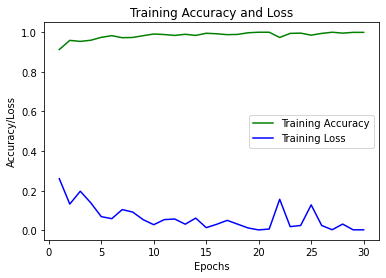

In [47]:
# Pulling test set for the each subject from data list
X_test_aa = data[0][3]
X_test_al = data[1][3]
X_test_av = data[2][3]
X_test_aw = data[3][3]
X_test_ay = data[4][3]

x_test_lis = [[X_test_aa], [X_test_al],[X_test_av], 
               [X_test_aw],[X_test_ay]]
#X_train_aug_ = X_train_aug.reshape(X_train_aug.shape[0], 201,6)
CNN_pred_list = CNN_classifier(X_train_aug_scaled_reshaped, y_train_aug_OHE, x_test_lis)

## Hybrid model

### Defining Hybrid model run

In [ ]:
# Defining final CNN model which takes training sets and fits to the set and returns
# trained model for evaluation
def run_Hybrid_Model(train_X, train_y):
  clear_session()
  reproducibility()
  
  start_time = time.time()
  
  # Hyperparameters
  batch_size = 5
  no_epochs = 80

  Hybridmodel=None
  Hybridmodel=cnnModel()
  
  
  Hybridmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Defining Early stopping and Checkpoint
  earlyStop = EarlyStopping(monitor='loss', 
                              mode = 'min',
                            patience=10) 
  Hybrid_model_checkpoint = ModelCheckpoint(filepath='/content/gdrive/My Drive/ITEC5920/FinalProject/Hyrbid_model.chkp.h5',
                                      save_best_only=False)


  # Fit data to model
  Hybrid_model_history = Hybridmodel.fit(train_X, train_y,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=1,
              callbacks=[earlyStop, Hybrid_model_checkpoint])
  
  time_1_1=time.time() - start_time
  print("--- %s seconds ---" % (time.time() - start_time))

  return Hybridmodel

### Gridsearch implementation for Hybrid model. As frist part of the hybrid model (CNN) was gridsearched, we are just going to check XGBoost part.

In [ ]:
def get_middle_output(x_train,y_train):
  clear_session()
  reproducibility()
  # creating Hybrid mmodel 
  Hybrid_model = run_Hybrid_Model(x_train,y_train)
  layer_name = 'middle_layer'
  middle_layer_model = Model(inputs = Hybrid_model.input,
                          outputs = Hybrid_model.get_layer(layer_name).output)

  middle_output = middle_layer_model.predict(x_train)
  
  return middle_output 
middle_output = get_middle_output(X_train_aug_scaled_reshaped, y_train_aug_OHE)

Epoch 1/80
312/312 [==============================] - 5s 14ms/step - loss: 0.2607 - accuracy: 0.9122
Epoch 2/80
312/312 [==============================] - 4s 14ms/step - loss: 0.1326 - accuracy: 0.9583
Epoch 3/80
312/312 [==============================] - 4s 14ms/step - loss: 0.1975 - accuracy: 0.9532
Epoch 4/80
312/312 [==============================] - 4s 14ms/step - loss: 0.1390 - accuracy: 0.9590
Epoch 5/80
312/312 [==============================] - 4s 14ms/step - loss: 0.0693 - accuracy: 0.9737
Epoch 6/80
312/312 [==============================] - 4s 14ms/step - loss: 0.0590 - accuracy: 0.9821
Epoch 7/80
312/312 [==============================] - 4s 14ms/step - loss: 0.1049 - accuracy: 0.9718
Epoch 8/80
312/312 [==============================] - 4s 14ms/step - loss: 0.0922 - accuracy: 0.9731
Epoch 9/80
312/312 [==============================] - 4s 14ms/step - loss: 0.0538 - accuracy: 0.9821
Epoch 10/80
312/312 [==============================] - 4s 14ms/step - loss: 0.0286 - accura

In [ ]:
def Hybrid_gridsearch(x_train, y_train):
  # Calling the constant randomizers 
  reproducibility()
  
  #  Handling multilable output for XGBoost
  xgbmodel = XGBClassifier( objective='multi:softprob', 
                            num_class= 2,
                            learning_rate=0.1,
                            n_estimators=100,
                            seed=42)

  multilabel_model = MultiOutputClassifier(estimator=xgbmodel)


  parameters = {'estimator__max_depth': range(2, 11, 1),
                'estimator__n_estimators': range(60, 221, 40),
                'estimator__learning_rate': [0.1, 0.01, 0.05]}

  hybrid_gridsearch = GridSearchCV( estimator=multilabel_model,
                                    param_grid=parameters,
                                    cv = 5,
                                    verbose=1,
                                    n_jobs=-1)
  hybrid_gridsearch_result=hybrid_gridsearch.fit(x_train, y_train)

  # summarize results
  print("Best: %f using %s" % (hybrid_gridsearch_result.best_score_, hybrid_gridsearch_result.best_params_))
  means = hybrid_gridsearch_result.cv_results_['mean_test_score']
  stds = hybrid_gridsearch_result.cv_results_['std_test_score']
  params = hybrid_gridsearch_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

Hybrid_gridsearch(middle_output, y_train_aug_OHE)


Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best: 0.998077 using {'estimator__learning_rate': 0.05, 'estimator__max_depth': 2, 'estimator__n_estimators': 60}
0.996154 (0.003738) with: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 2, 'estimator__n_estimators': 60}
0.996795 (0.002867) with: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 2, 'estimator__n_estimators': 100}
0.996795 (0.002867) with: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 2, 'estimator__n_estimators': 140}
0.996795 (0.002867) with: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 2, 'estimator__n_estimators': 180}
0.996795 (0.002867) with: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 2, 'estimator__n_estimators': 220}
0.997436 (0.002398) with: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 60}
0.997436 (0.002398) with: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators

### Defining Hybrid model classifier

In [ ]:
def Hybrid_classifier(x_train, y_train, test_list):
  # x_train, y_train, test_list=CNN_prep(x_train, y_train, test_list)
  clear_session()
  reproducibility()
  
  Hybrid_model = run_Hybrid_Model(x_train,y_train)
  layer_name = 'middle_layer'
  middle_layer_model = Model(inputs = Hybrid_model.input,
                           outputs = Hybrid_model.get_layer(layer_name).output)
  
  middle_output = middle_layer_model.predict(x_train) 
  
  middle_test_output_list=[]
  for l in test_list:
    middle_test_output_list.append(middle_layer_model.predict(l))
  
    
  #  Handling multilable output for XGBoost
  xgbmodel = XGBClassifier( objective='multi:softprob', 
                            num_class=2,
                            learning_rate=0.05,
                            n_estimators=60,
                            max_depth=2,
                            seed=42)

  multilabel_model = MultiOutputClassifier(xgbmodel)

  #xgbmodel = XGBClassifier()                      
  multilabel_model.fit(middle_output, y_train)

  predict_list = []
  
  for i in middle_test_output_list:
    arr = np.asarray(multilabel_model.predict_proba(i))[1]
    predict_list.append(arr)
  return predict_list

In [ ]:
x_test_lis = [[X_test_aa], [X_test_al],[X_test_av], 
               [X_test_aw],[X_test_ay]]
X_train_aug_ = X_train_aug.reshape(X_train_aug.shape[0], 201,6,1)
Hybrid_pred_list = Hybrid_classifier(X_train_aug_scaled_reshaped, y_train_aug_OHE, x_test_lis)

Epoch 1/80
312/312 [==============================] - 5s 13ms/step - loss: 0.2607 - accuracy: 0.9122
Epoch 2/80
312/312 [==============================] - 4s 14ms/step - loss: 0.1326 - accuracy: 0.9583
Epoch 3/80
312/312 [==============================] - 4s 14ms/step - loss: 0.1975 - accuracy: 0.9532
Epoch 4/80
312/312 [==============================] - 4s 14ms/step - loss: 0.1390 - accuracy: 0.9590
Epoch 5/80
312/312 [==============================] - 4s 14ms/step - loss: 0.0693 - accuracy: 0.9737
Epoch 6/80
312/312 [==============================] - 4s 14ms/step - loss: 0.0590 - accuracy: 0.9821
Epoch 7/80
312/312 [==============================] - 4s 14ms/step - loss: 0.1049 - accuracy: 0.9718
Epoch 8/80
312/312 [==============================] - 4s 14ms/step - loss: 0.0922 - accuracy: 0.9731
Epoch 9/80
312/312 [==============================] - 4s 14ms/step - loss: 0.0538 - accuracy: 0.9821
Epoch 10/80
312/312 [==============================] - 4s 14ms/step - loss: 0.0286 - accura

## Ensemble Learning Model

In [ ]:

def EEG_ensemble_soft(MLPpred,ViTpred, CnnPred, HybridPred):
  i = 0
  soft_vote_list = []
  for y in MLPpred:
    x = ViTpred[i]
    C = CnnPred[i]
    H = HybridPred[i]
    soft_vote = x + y + C + H 
    i+=1
    soft_vote_list.append(soft_vote)
  return soft_vote_list  




## Model Evaluation

### Function to evaluate performance of the model given prediction list

In [ ]:
sn.set(rc={"figure.dpi":200, 'savefig.dpi':200})  # Setting resolution for Seaborn

# The latest performance metric function
def Performance(classifierName,predictionList, data):
  _accuracy_scores = []
  loss = []
  _f1_scores = []
  _precision_scores = []
  _recall_scores = []
  AUCs = []
  ROCs = []
  pred_all = 0
  test_all = 0
  subjects=['AA','AL','AV','AW','AY'] #Name of the subjects
  test_list=[]
  # Uncpacking data and adding test values to the list
  for test in data: 
    test_list.append(test[5]) 
    # test_all += test[5]

  predicted_binary=[]
  # Converting probabilities to binary in predicition 
  
  for prob in predictionList:
    predicted_binary.append((np.argmax(prob,axis=1)))

  print('Performance results for ', classifierName )
  print('')
  for i in range(5):
    # Accuracy
    _accuracy_score=accuracy_score(test_list[i], predicted_binary[i])
    _accuracy_scores.append(_accuracy_score)
    print('------------------------------------------------------------------------')
    print(f'   > Accuracy for "{subjects[i]}" test set : {round(_accuracy_score*100,2)}% ')
    # F1 Score Calculation
    _f1_score = f1_score(test_list[i], predicted_binary[i])
    _f1_scores.append(_f1_score)
    print(f'   > f1 score for "{subjects[i]}" test set : {round(_f1_score*100,2)}% ')
    # Percision Calculation
    _precision_score = precision_score(test_list[i], predicted_binary[i])
    _precision_scores.append(_precision_score)
    print(f'   > Precision score for "{subjects[i]}" test set : {round(_precision_score*100,2)}% ')
    # Recall Calculation
    _recall_score = recall_score(test_list[i], predicted_binary[i])
    _recall_scores.append(_recall_score)
    print(f'   > Recall score for "{subjects[i]}" test set : {round(_recall_score,3)} ')
    # AUC valu and ROC Curve
    AUC = roc_auc_score(test_list[i], predicted_binary[i])
    AUCs.append(AUC)
    
    print(f'   > AUC score for "{subjects[i]}" test set : {round(AUC,3)} ')
    print('------------------------------------------------------------------------')

    fpr_model, tpr_model, thresholds_model = roc_curve(test_list[i], predicted_binary[i])
    roc_auc_model = auc(fpr_model, tpr_model)
    display_model = RocCurveDisplay(fpr=fpr_model, tpr=tpr_model, 
                                  roc_auc=roc_auc_model, 
                                  estimator_name=('ROC for subject '+ (test[0]).upper()))
    ROCs.append([fpr_model, tpr_model, 'Subject '+ (subjects[i]+' (AUC: '+"{:.2%})".format(AUC)).upper()])
    

    data_rep_1 = {'y_Actual':test_list[i].ravel(), 'y_Predicted': predicted_binary[i].ravel()}
    data_df_1 = pd.DataFrame(data_rep_1, columns=['y_Actual','y_Predicted'])
    confusion_matrix_1 = pd.crosstab(data_df_1['y_Actual'], data_df_1['y_Predicted'], 
                               rownames=['Actual'], colnames=['Predicted'],margins = True)
    figure = sn.heatmap(confusion_matrix_1, annot=True, fmt='g')
    figure.set_title('Confusion Matrix for subject '+str(subjects[i]))
    heatmap = figure.get_figure()
    #heatmap.savefig('Figure1.jpg', dpi=400)
    plt.show()

  print(f'\nAverage test sets accuracies: {round(np.mean(_accuracy_scores),4)*100}% (+- {round(np.std(_accuracy_scores),4)})')
  print(f'\nAverage test sets f1 score: {round(np.mean(_f1_scores),4)}')
  print(f'\nAverage test sets precision scores: {round(np.mean(_precision_scores),4)}')
  print(f'\nAverage test sets recall score: {round(np.mean(_recall_scores),4)}')
  print(f'\nAverage test sets AUCs: {round(np.mean(AUCs),4)}')

  for i in ROCs: 
    plt.plot(i[0],i[1], label = i[2])
  
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title('Receiver Operating Characteristic Curve')
  plt.legend()
  plt.show()


Performance results for  MLP model

------------------------------------------------------------------------
   > Accuracy for "AA" test set : 91.96% 
   > f1 score for "AA" test set : 91.74% 
   > Precision score for "AA" test set : 94.34% 
   > Recall score for "AA" test set : 0.893 
   > AUC score for "AA" test set : 0.92 
------------------------------------------------------------------------


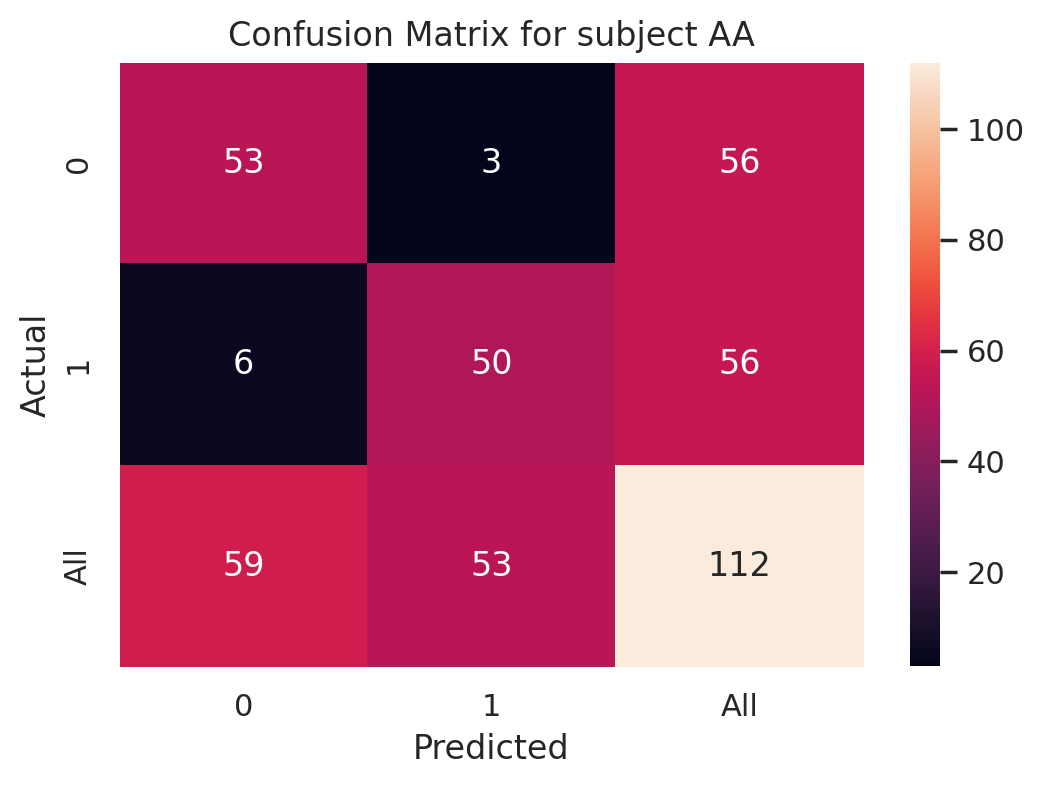

------------------------------------------------------------------------
   > Accuracy for "AL" test set : 92.86% 
   > f1 score for "AL" test set : 92.59% 
   > Precision score for "AL" test set : 96.15% 
   > Recall score for "AL" test set : 0.893 
   > AUC score for "AL" test set : 0.929 
------------------------------------------------------------------------


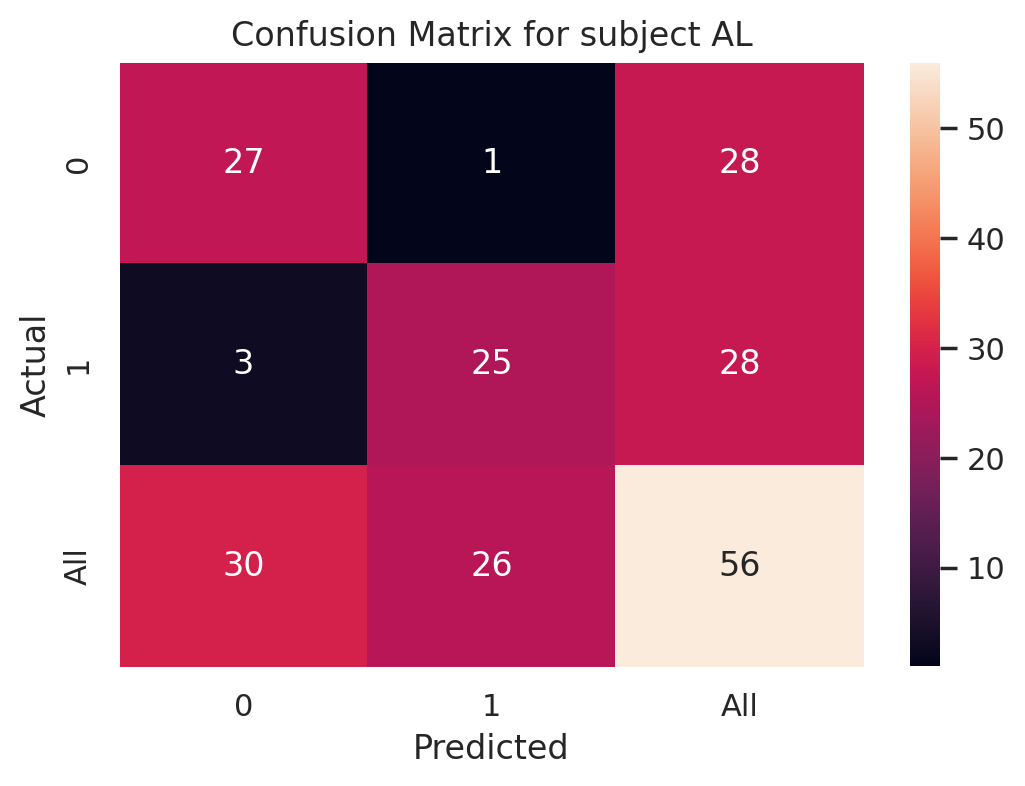

------------------------------------------------------------------------
   > Accuracy for "AV" test set : 83.67% 
   > f1 score for "AV" test set : 82.61% 
   > Precision score for "AV" test set : 88.37% 
   > Recall score for "AV" test set : 0.776 
   > AUC score for "AV" test set : 0.837 
------------------------------------------------------------------------


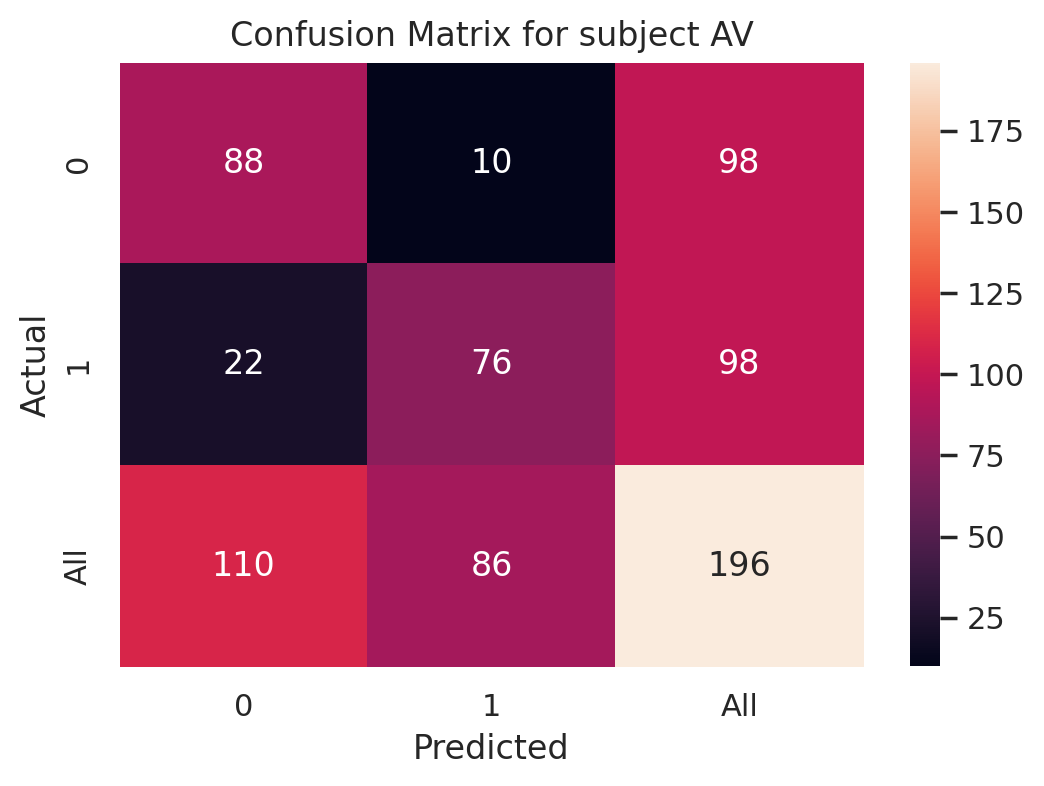

------------------------------------------------------------------------
   > Accuracy for "AW" test set : 91.96% 
   > f1 score for "AW" test set : 91.89% 
   > Precision score for "AW" test set : 92.73% 
   > Recall score for "AW" test set : 0.911 
   > AUC score for "AW" test set : 0.92 
------------------------------------------------------------------------


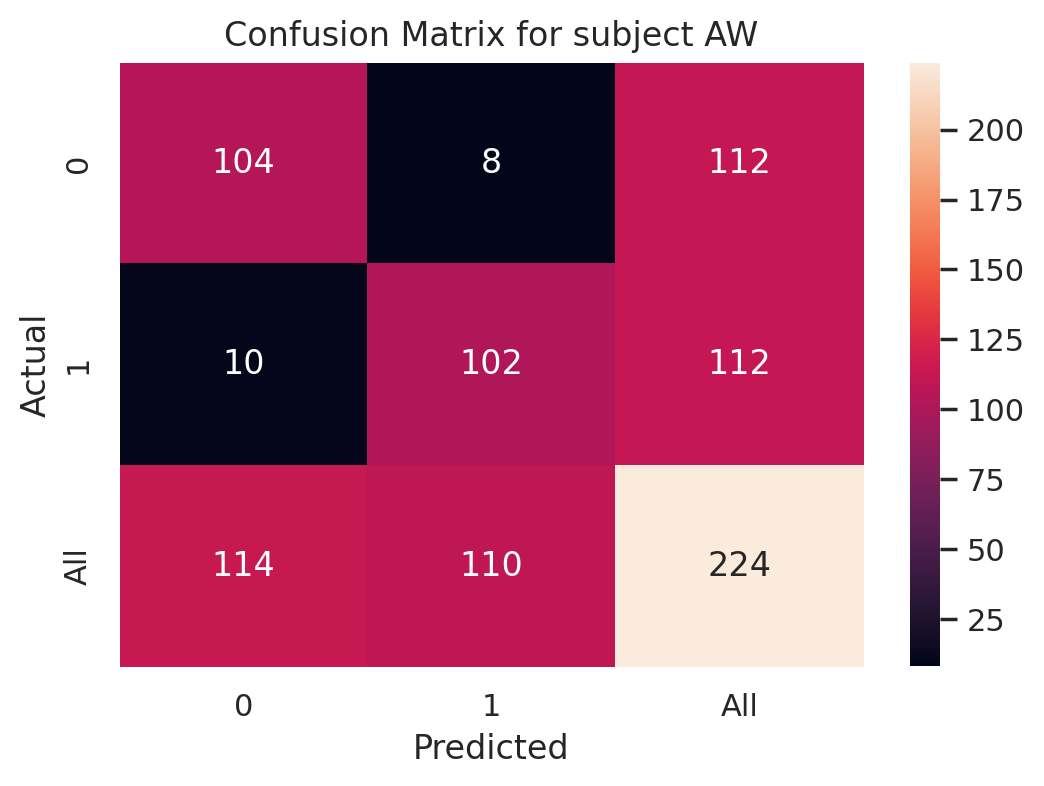

------------------------------------------------------------------------
   > Accuracy for "AY" test set : 92.86% 
   > f1 score for "AY" test set : 92.8% 
   > Precision score for "AY" test set : 93.55% 
   > Recall score for "AY" test set : 0.921 
   > AUC score for "AY" test set : 0.929 
------------------------------------------------------------------------


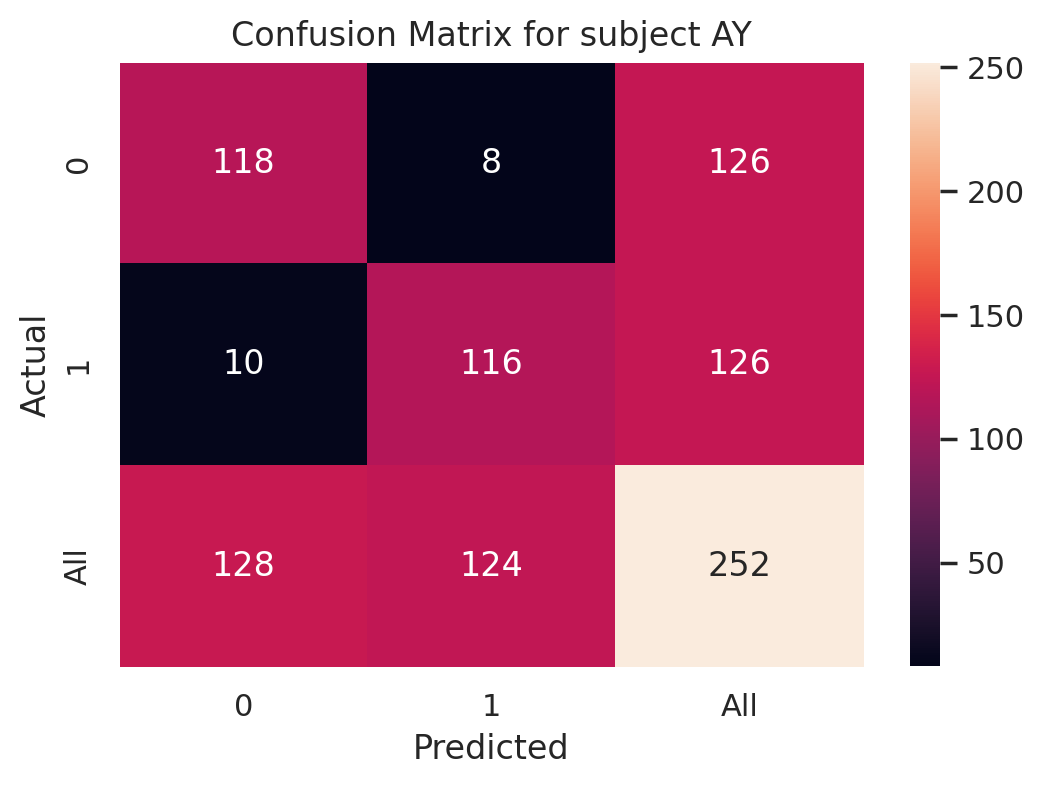


Average test sets accuracies: 90.66% (+- 0.0352)

Average test sets f1 score: 0.9033

Average test sets precision scores: 0.9303

Average test sets recall score: 0.8785

Average test sets AUCs: 0.9066


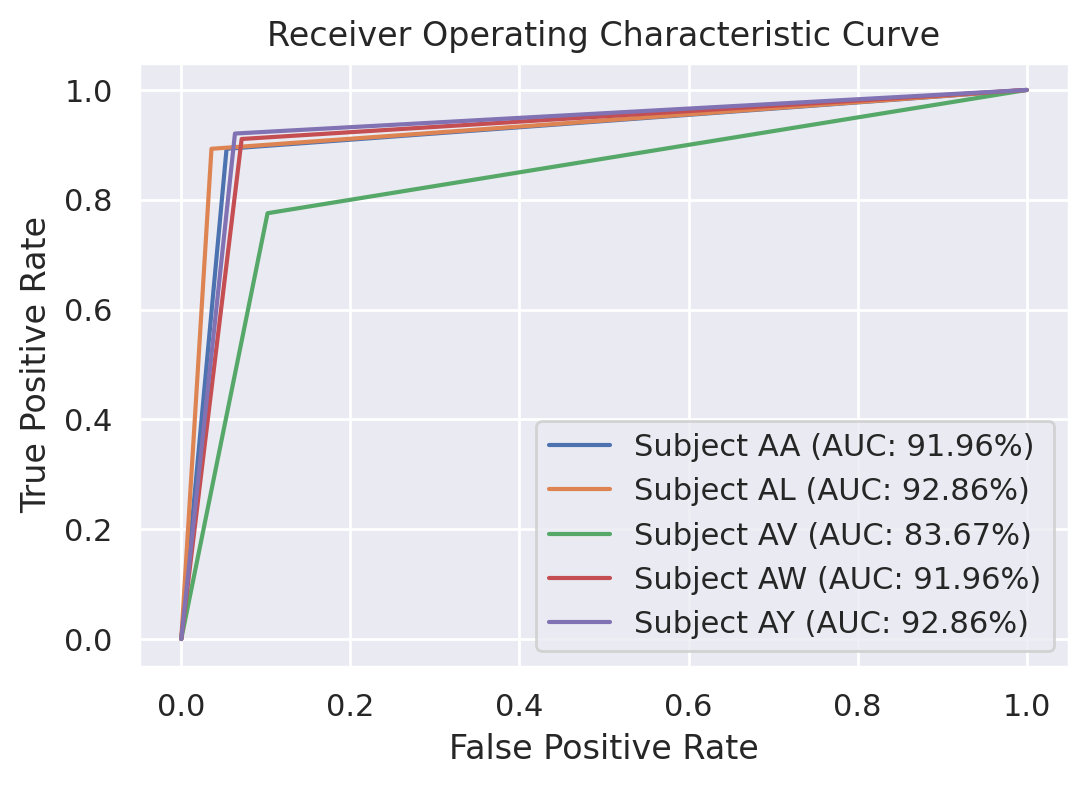

In [ ]:
Performance('MLP model', MLP_pred_list,data)

Performance results for  Transformer model

------------------------------------------------------------------------
   > Accuracy for "AA" test set : 93.75% 
   > f1 score for "AA" test set : 93.69% 
   > Precision score for "AA" test set : 94.55% 
   > Recall score for "AA" test set : 0.929 
   > AUC score for "AA" test set : 0.938 
------------------------------------------------------------------------


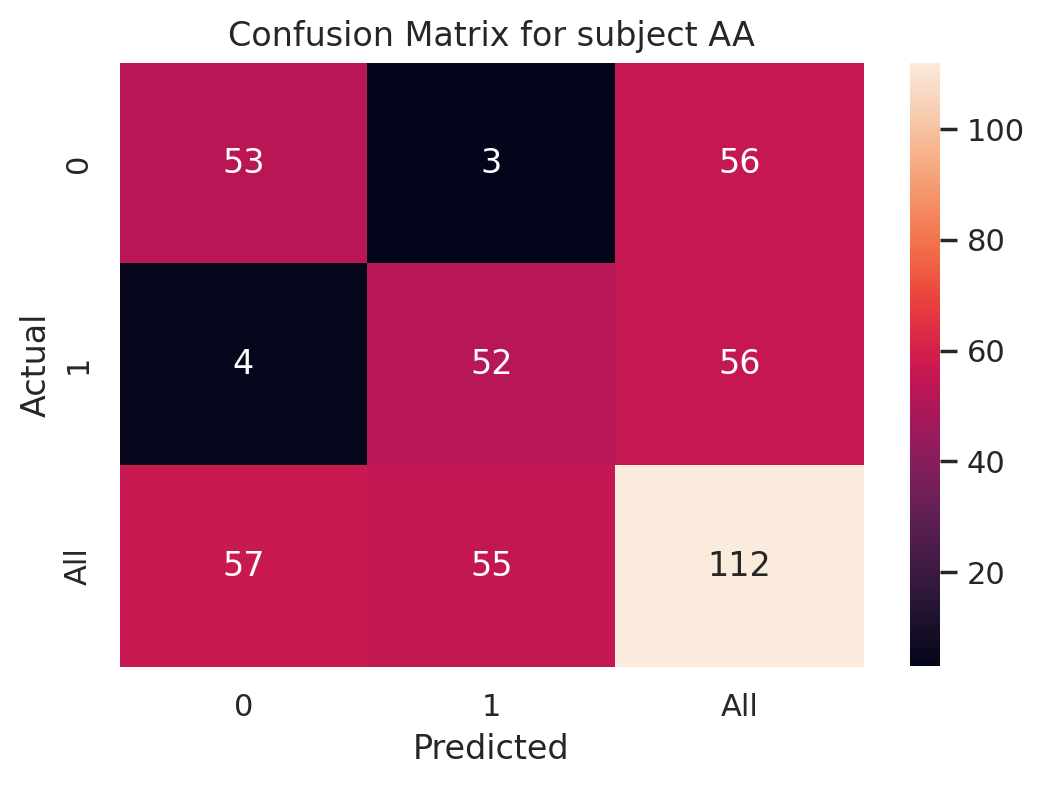

------------------------------------------------------------------------
   > Accuracy for "AL" test set : 94.64% 
   > f1 score for "AL" test set : 94.55% 
   > Precision score for "AL" test set : 96.3% 
   > Recall score for "AL" test set : 0.929 
   > AUC score for "AL" test set : 0.946 
------------------------------------------------------------------------


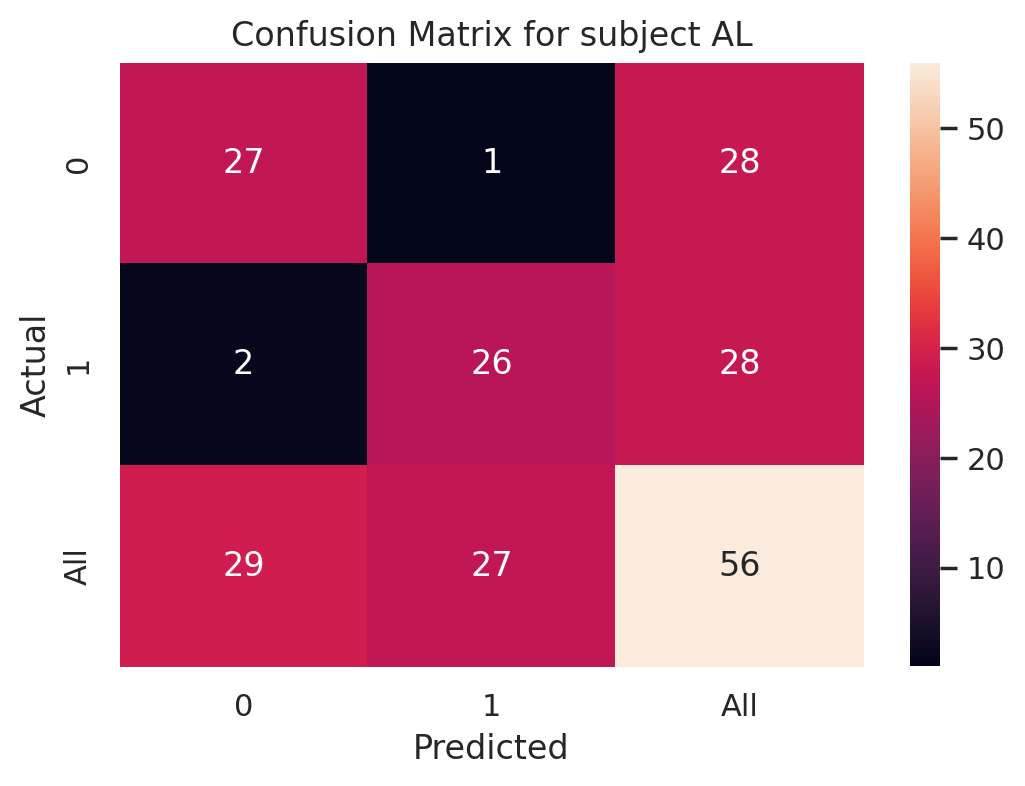

------------------------------------------------------------------------
   > Accuracy for "AV" test set : 86.22% 
   > f1 score for "AV" test set : 85.41% 
   > Precision score for "AV" test set : 90.8% 
   > Recall score for "AV" test set : 0.806 
   > AUC score for "AV" test set : 0.862 
------------------------------------------------------------------------


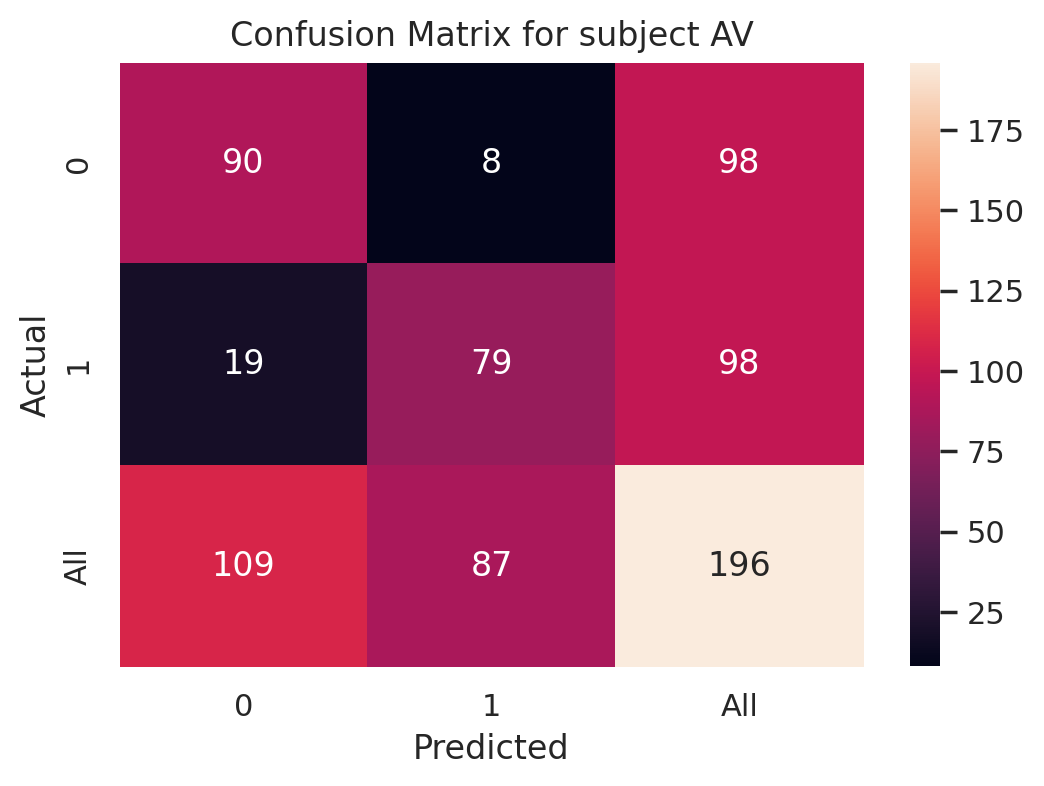

------------------------------------------------------------------------
   > Accuracy for "AW" test set : 91.07% 
   > f1 score for "AW" test set : 90.99% 
   > Precision score for "AW" test set : 91.82% 
   > Recall score for "AW" test set : 0.902 
   > AUC score for "AW" test set : 0.911 
------------------------------------------------------------------------


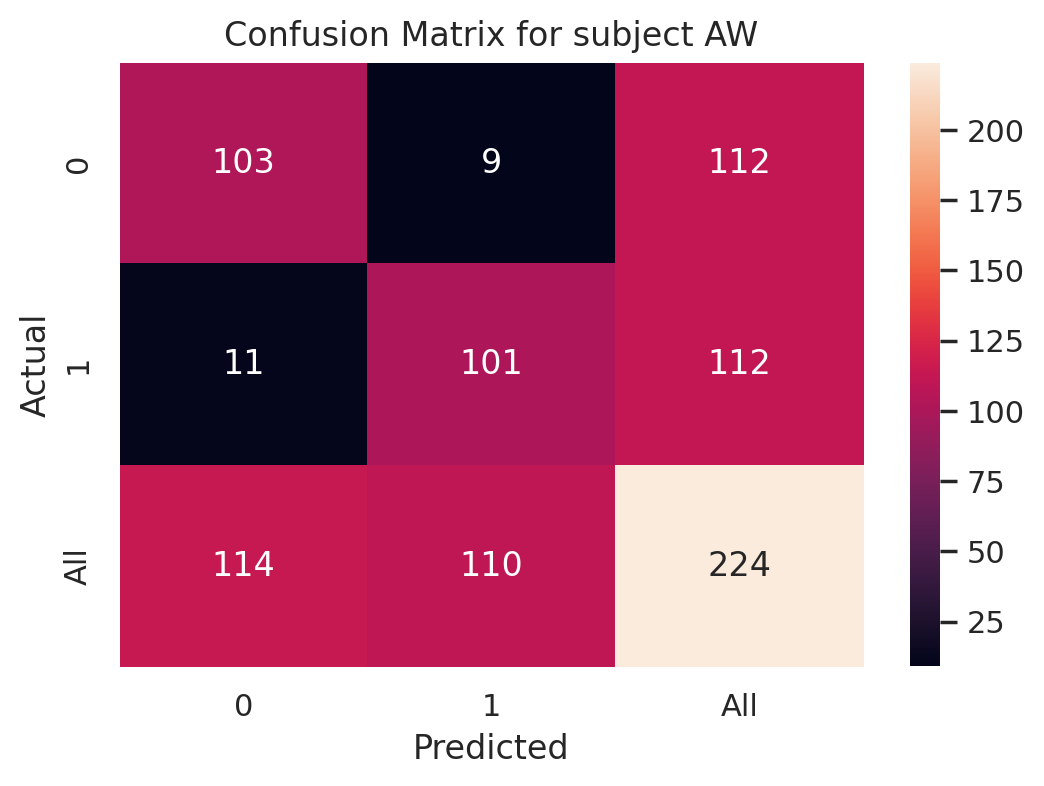

------------------------------------------------------------------------
   > Accuracy for "AY" test set : 92.06% 
   > f1 score for "AY" test set : 92.0% 
   > Precision score for "AY" test set : 92.74% 
   > Recall score for "AY" test set : 0.913 
   > AUC score for "AY" test set : 0.921 
------------------------------------------------------------------------


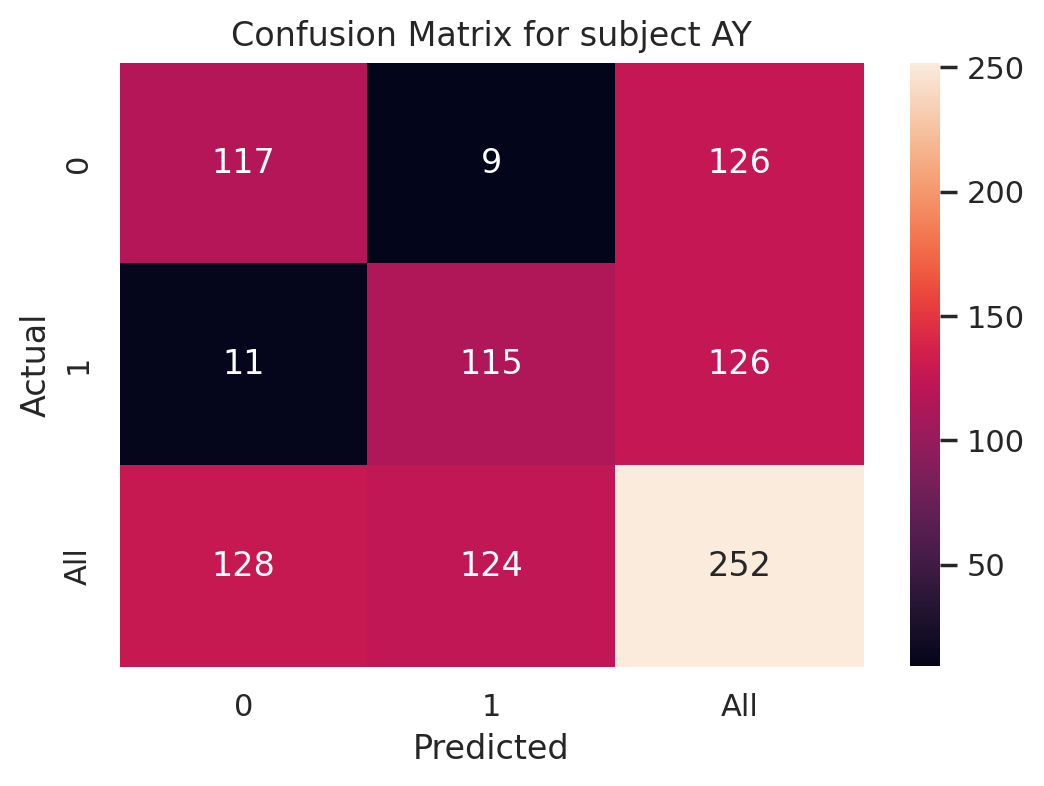


Average test sets accuracies: 91.55% (+- 0.0294)

Average test sets f1 score: 0.9133

Average test sets precision scores: 0.9324

Average test sets recall score: 0.8955

Average test sets AUCs: 0.9155


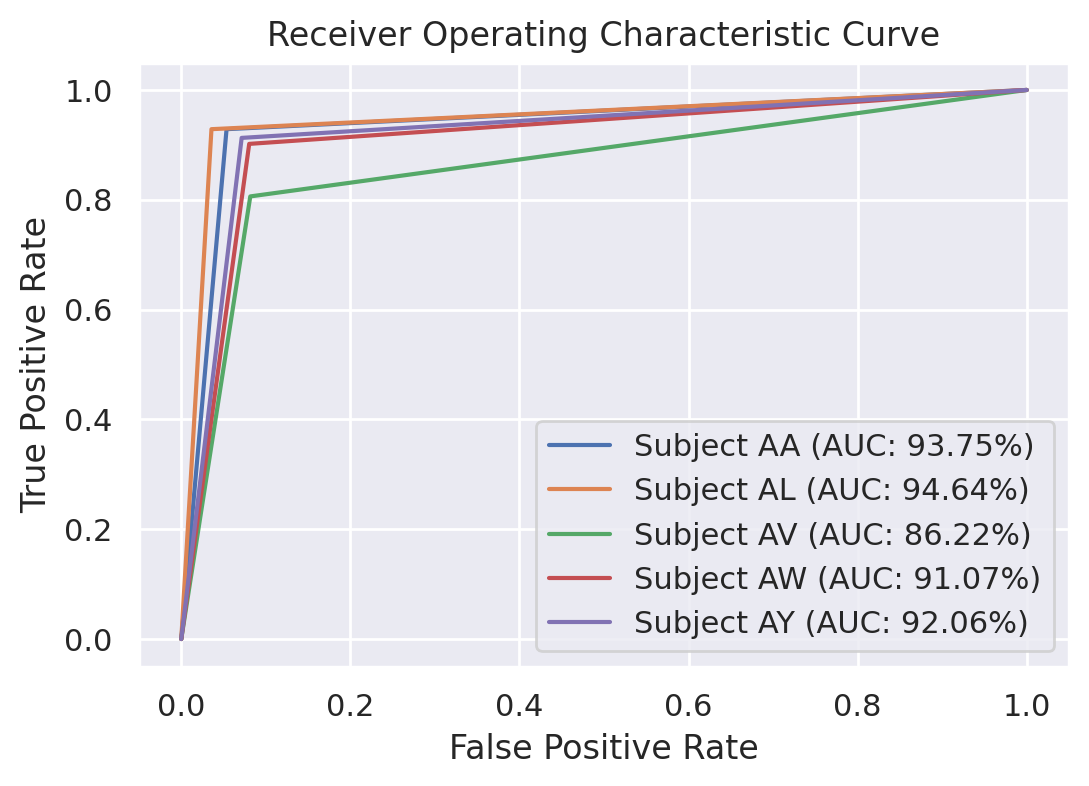

In [ ]:
Performance('Transformer model', vit_pred_list,data)

Performance results for  CNN model

------------------------------------------------------------------------
   > Accuracy for "AA" test set : 93.75% 
   > f1 score for "AA" test set : 94.02% 
   > Precision score for "AA" test set : 90.16% 
   > Recall score for "AA" test set : 0.982 
   > AUC score for "AA" test set : 0.938 
------------------------------------------------------------------------


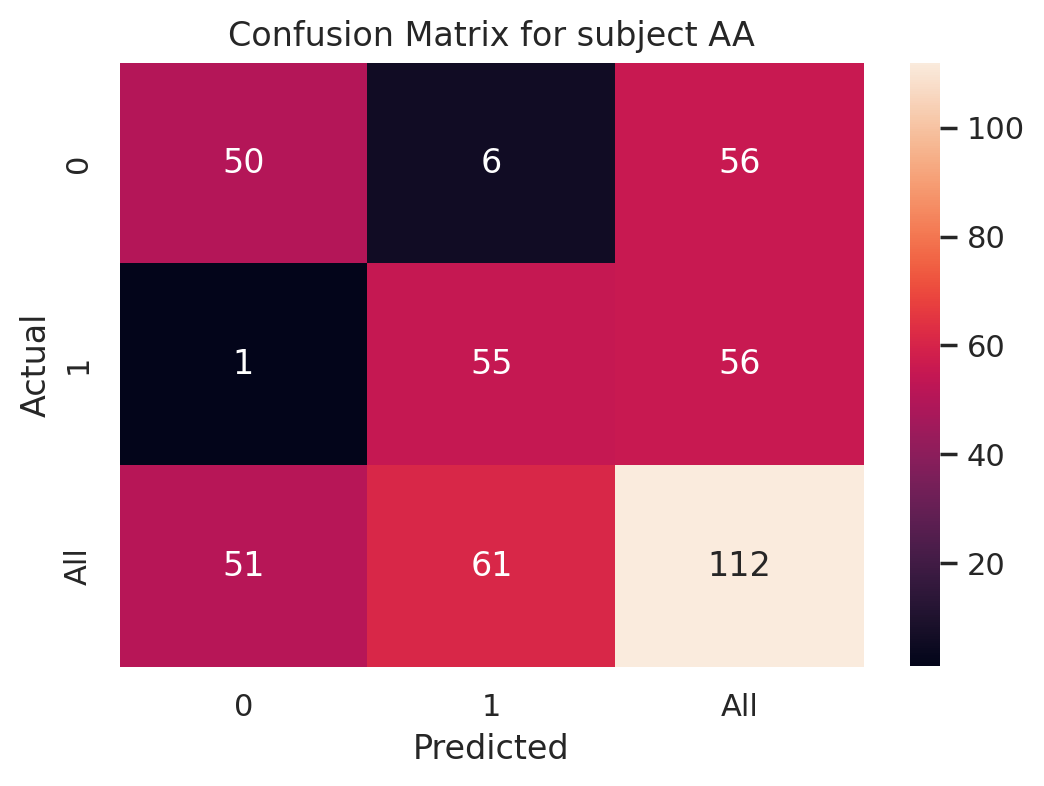

------------------------------------------------------------------------
   > Accuracy for "AL" test set : 94.64% 
   > f1 score for "AL" test set : 94.74% 
   > Precision score for "AL" test set : 93.1% 
   > Recall score for "AL" test set : 0.964 
   > AUC score for "AL" test set : 0.946 
------------------------------------------------------------------------


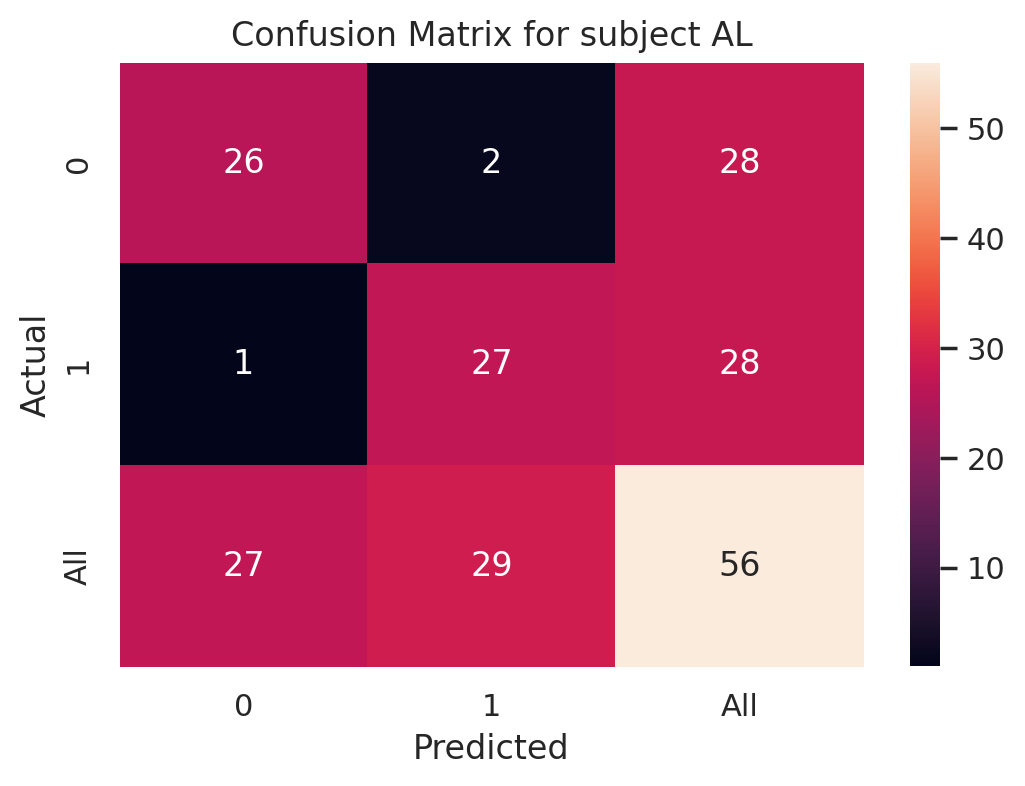

------------------------------------------------------------------------
   > Accuracy for "AV" test set : 86.22% 
   > f1 score for "AV" test set : 86.7% 
   > Precision score for "AV" test set : 83.81% 
   > Recall score for "AV" test set : 0.898 
   > AUC score for "AV" test set : 0.862 
------------------------------------------------------------------------


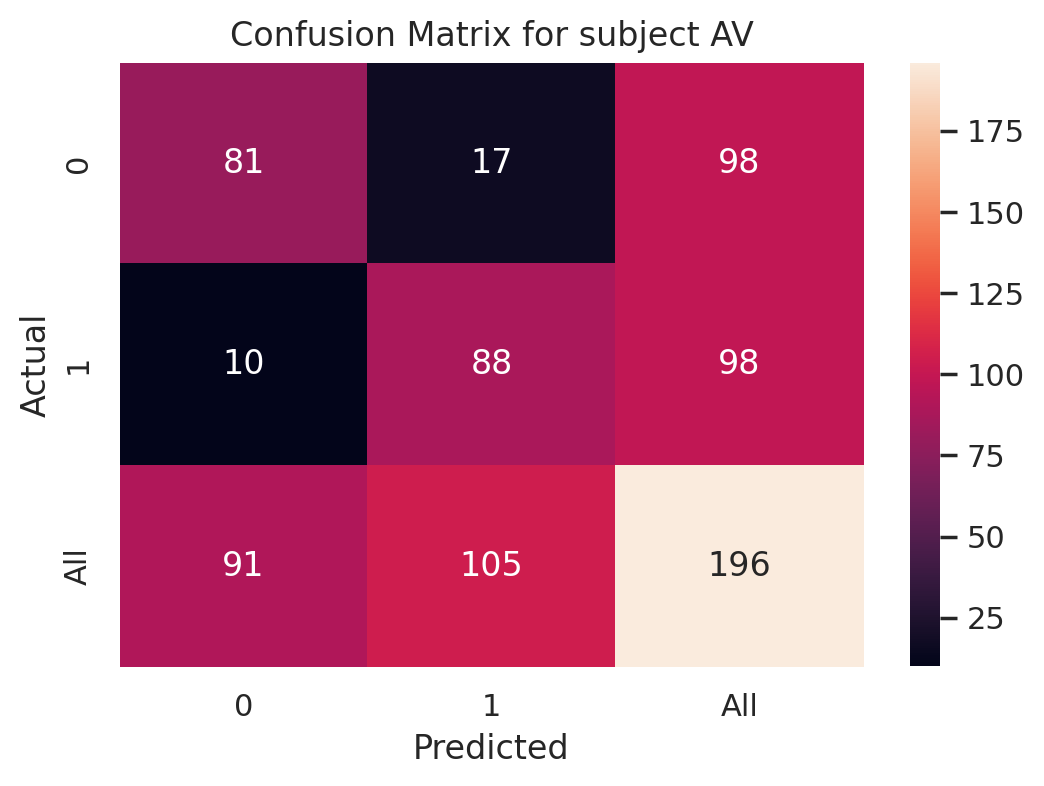

------------------------------------------------------------------------
   > Accuracy for "AW" test set : 87.05% 
   > f1 score for "AW" test set : 88.07% 
   > Precision score for "AW" test set : 81.68% 
   > Recall score for "AW" test set : 0.955 
   > AUC score for "AW" test set : 0.871 
------------------------------------------------------------------------


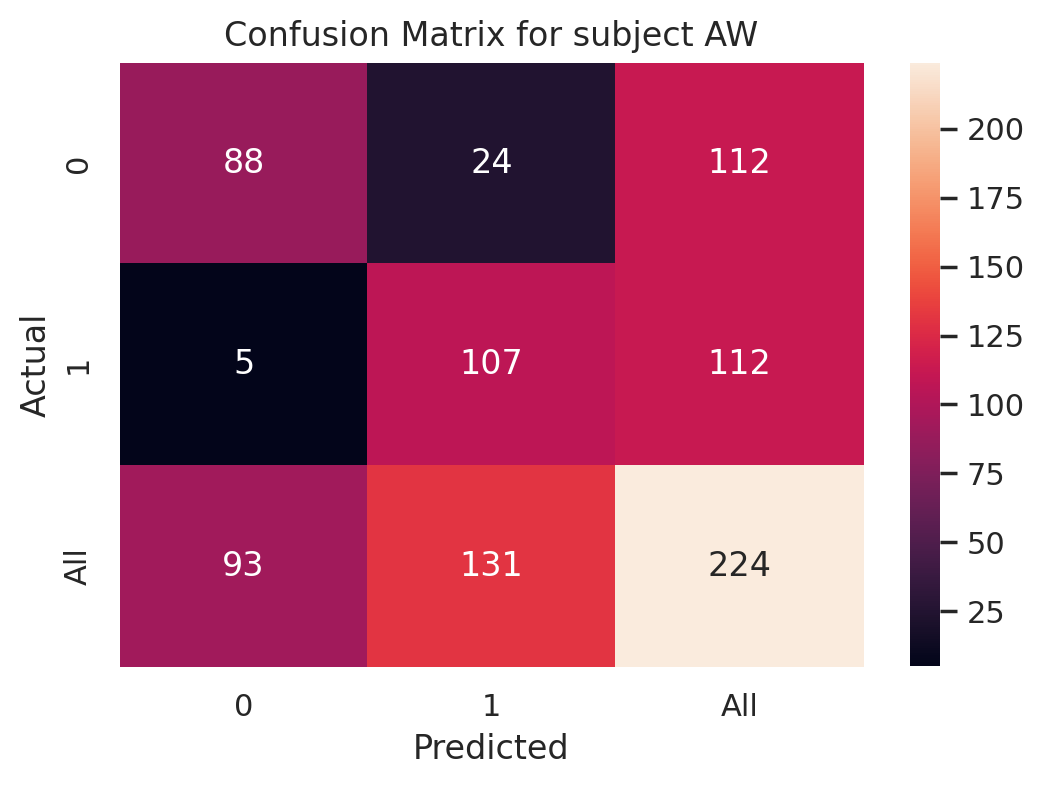

------------------------------------------------------------------------
   > Accuracy for "AY" test set : 87.3% 
   > f1 score for "AY" test set : 88.24% 
   > Precision score for "AY" test set : 82.19% 
   > Recall score for "AY" test set : 0.952 
   > AUC score for "AY" test set : 0.873 
------------------------------------------------------------------------


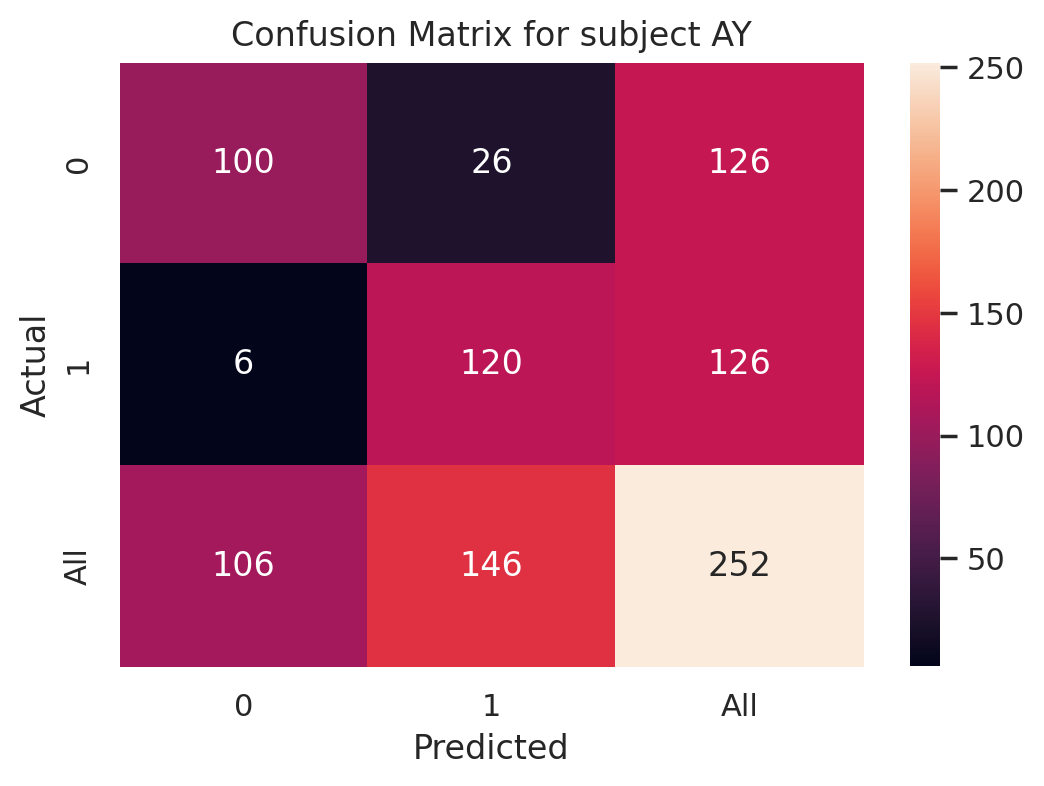


Average test sets accuracies: 89.79% (+- 0.0362)

Average test sets f1 score: 0.9035

Average test sets precision scores: 0.8619

Average test sets recall score: 0.9504

Average test sets AUCs: 0.8979


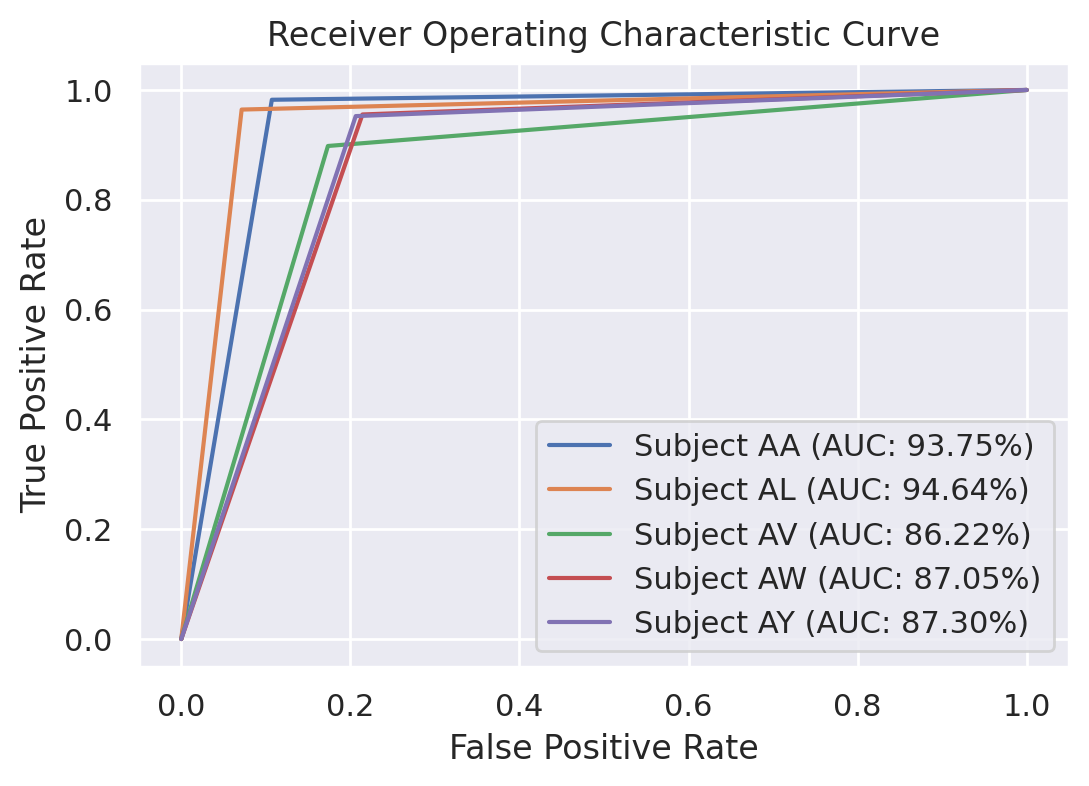

In [ ]:
Performance('CNN model', CNN_pred_list,data)

Performance results for  Hybrid model

------------------------------------------------------------------------
   > Accuracy for "AA" test set : 91.07% 
   > f1 score for "AA" test set : 91.23% 
   > Precision score for "AA" test set : 89.66% 
   > Recall score for "AA" test set : 0.929 
   > AUC score for "AA" test set : 0.911 
------------------------------------------------------------------------


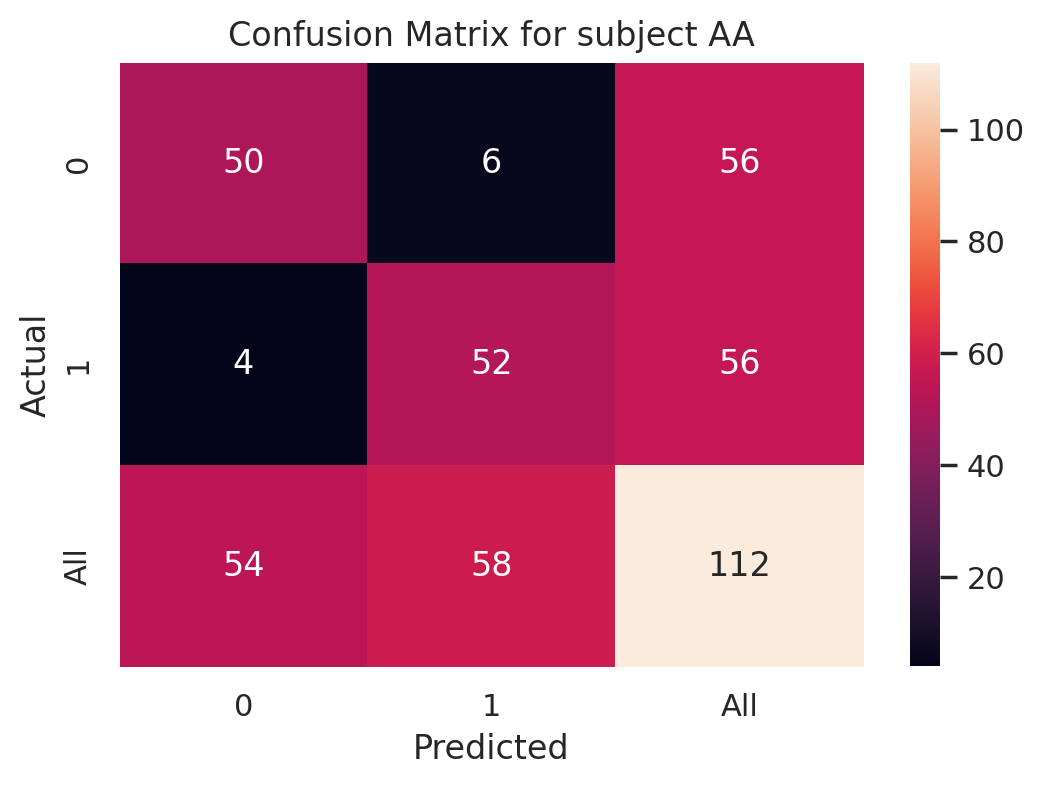

------------------------------------------------------------------------
   > Accuracy for "AL" test set : 89.29% 
   > f1 score for "AL" test set : 90.0% 
   > Precision score for "AL" test set : 84.38% 
   > Recall score for "AL" test set : 0.964 
   > AUC score for "AL" test set : 0.893 
------------------------------------------------------------------------


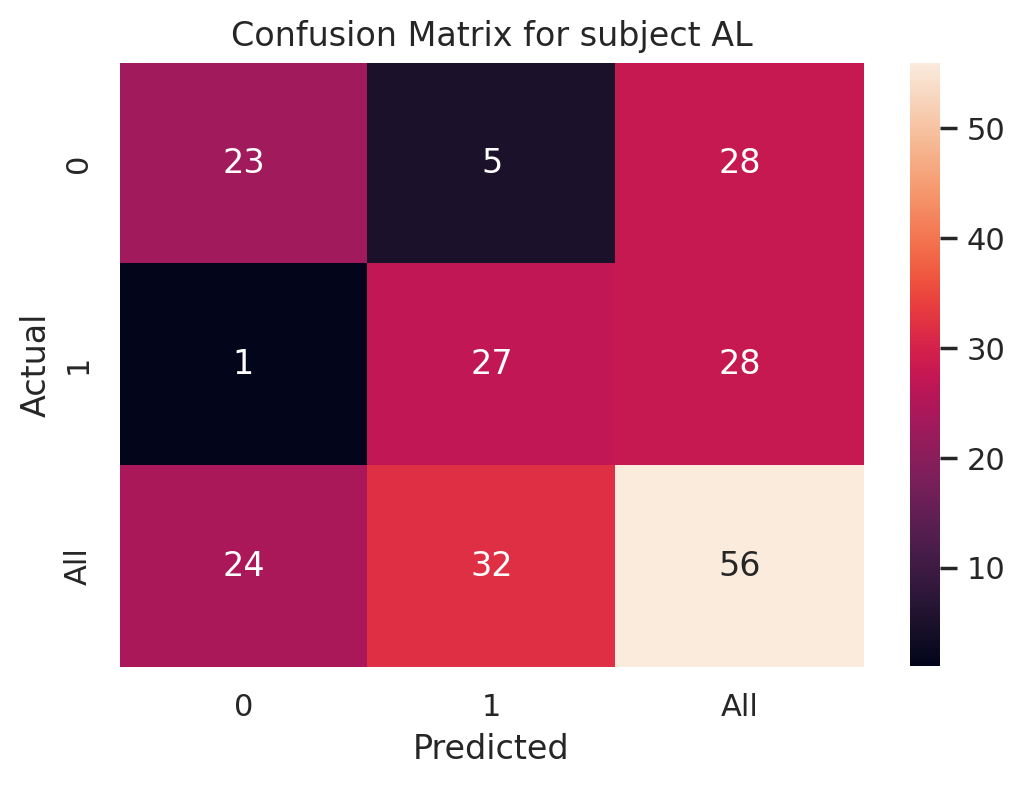

------------------------------------------------------------------------
   > Accuracy for "AV" test set : 80.1% 
   > f1 score for "AV" test set : 80.79% 
   > Precision score for "AV" test set : 78.1% 
   > Recall score for "AV" test set : 0.837 
   > AUC score for "AV" test set : 0.801 
------------------------------------------------------------------------


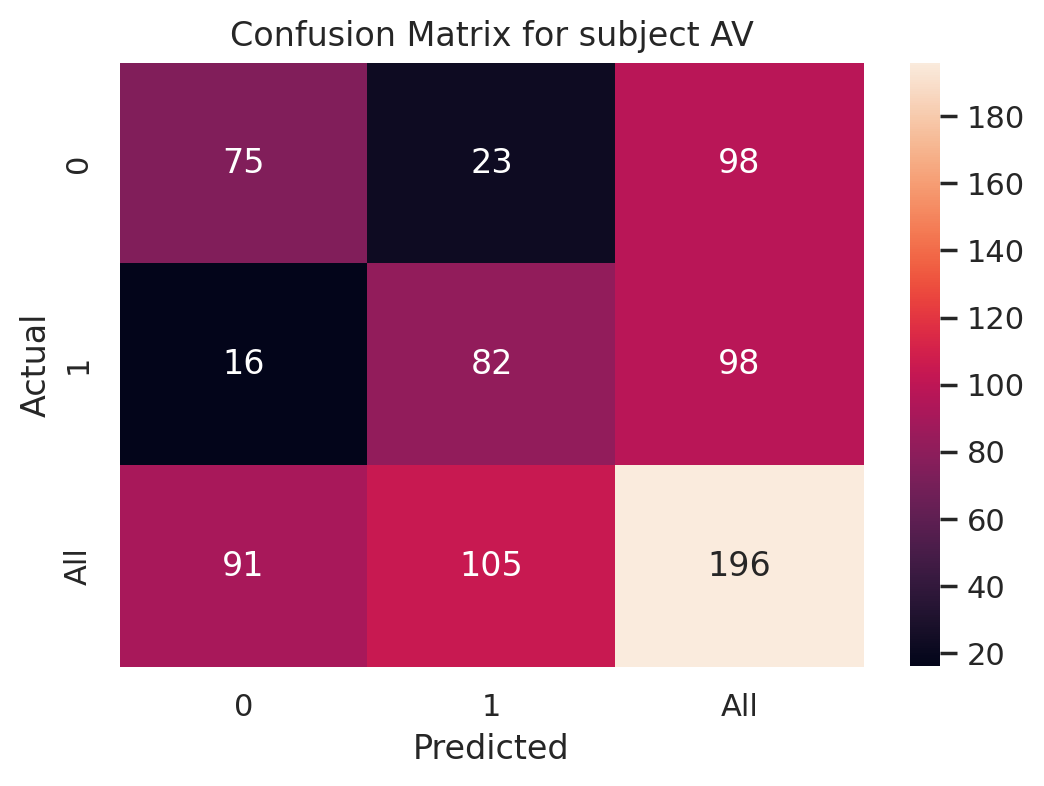

------------------------------------------------------------------------
   > Accuracy for "AW" test set : 87.5% 
   > f1 score for "AW" test set : 88.62% 
   > Precision score for "AW" test set : 81.34% 
   > Recall score for "AW" test set : 0.973 
   > AUC score for "AW" test set : 0.875 
------------------------------------------------------------------------


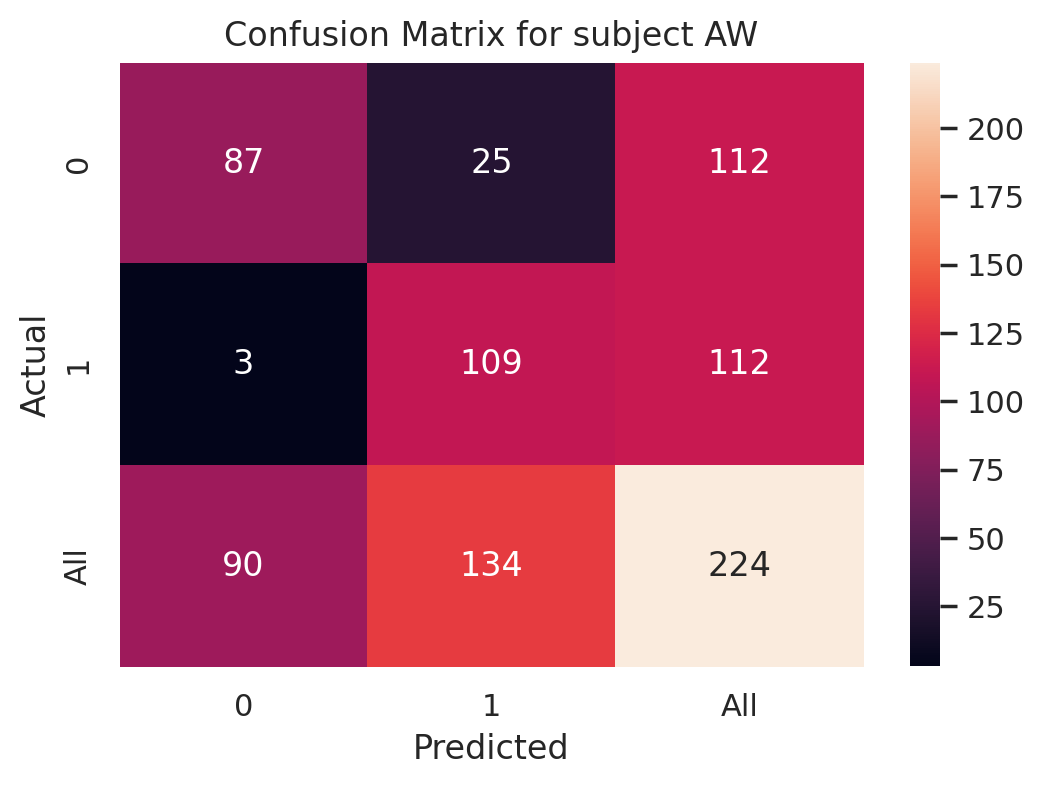

------------------------------------------------------------------------
   > Accuracy for "AY" test set : 87.3% 
   > f1 score for "AY" test set : 88.41% 
   > Precision score for "AY" test set : 81.33% 
   > Recall score for "AY" test set : 0.968 
   > AUC score for "AY" test set : 0.873 
------------------------------------------------------------------------


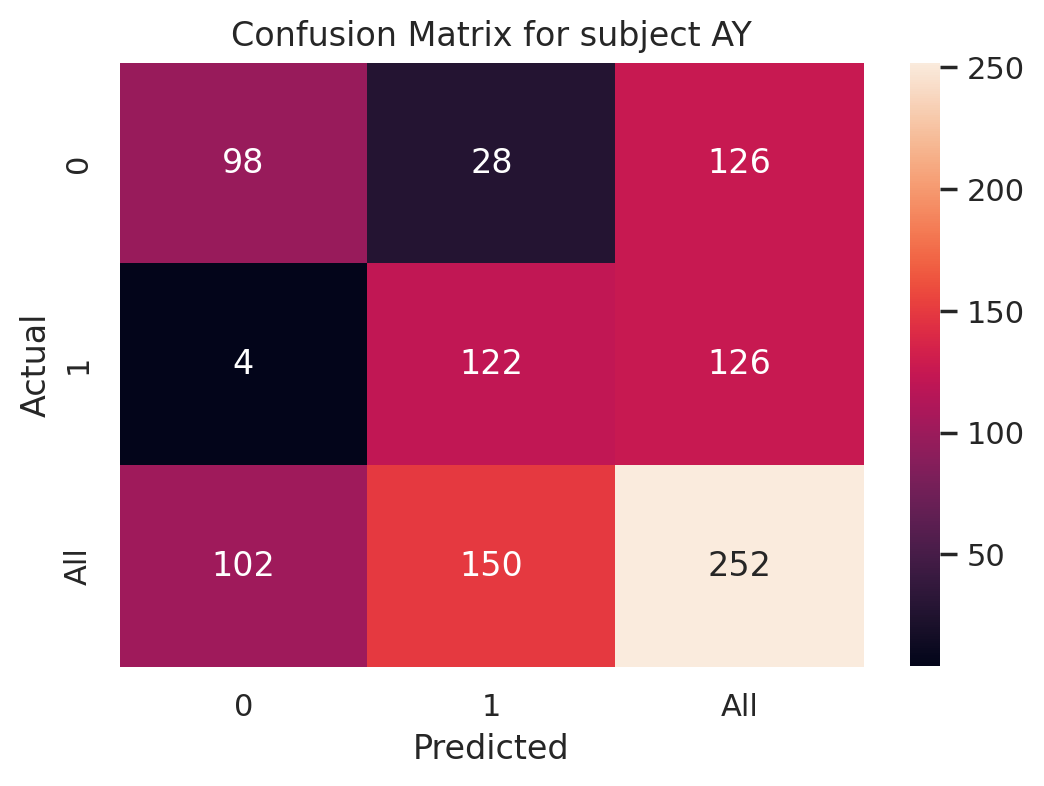


Average test sets accuracies: 87.05000000000001% (+- 0.0373)

Average test sets f1 score: 0.8781

Average test sets precision scores: 0.8296

Average test sets recall score: 0.9342

Average test sets AUCs: 0.8705


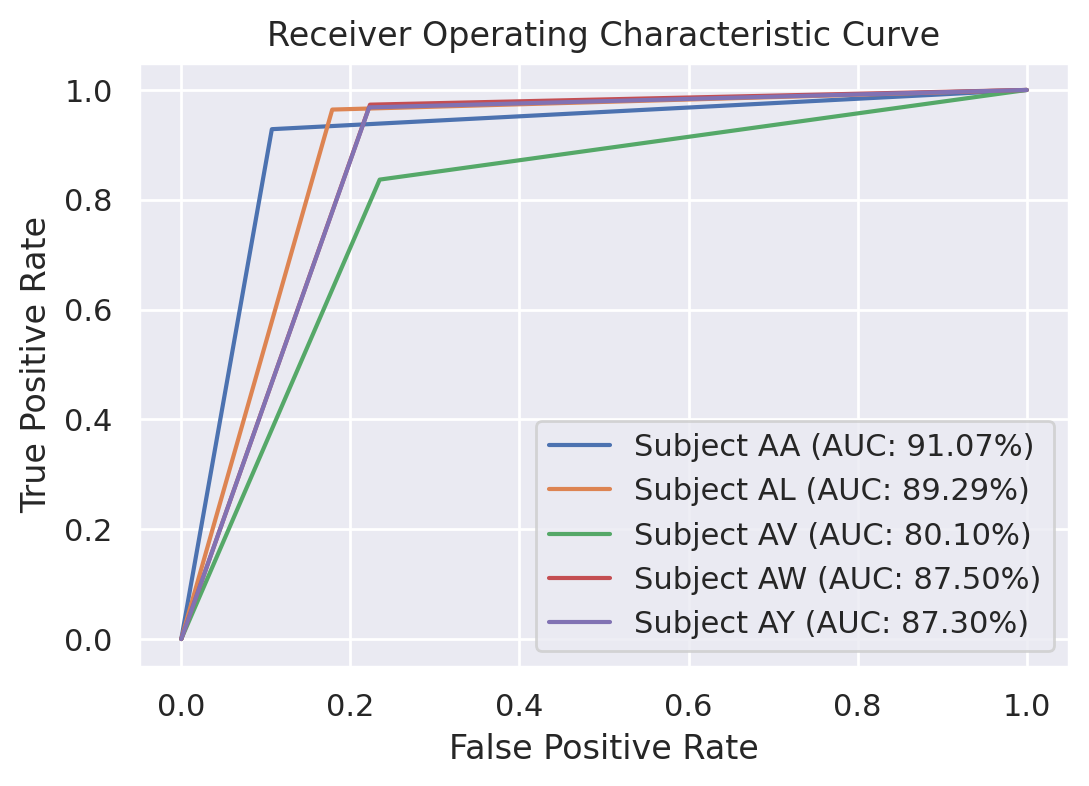

In [ ]:
Performance('Hybrid model', Hybrid_pred_list,data)

In [ ]:
SoftCLf = EEG_ensemble_soft(MLP_pred_list,vit_pred_list, CNN_pred_list, Hybrid_pred_list)

Performance results for  SoftCLf model

------------------------------------------------------------------------
   > Accuracy for "AA" test set : 91.07% 
   > f1 score for "AA" test set : 90.91% 
   > Precision score for "AA" test set : 92.59% 
   > Recall score for "AA" test set : 0.893 
   > AUC score for "AA" test set : 0.911 
------------------------------------------------------------------------


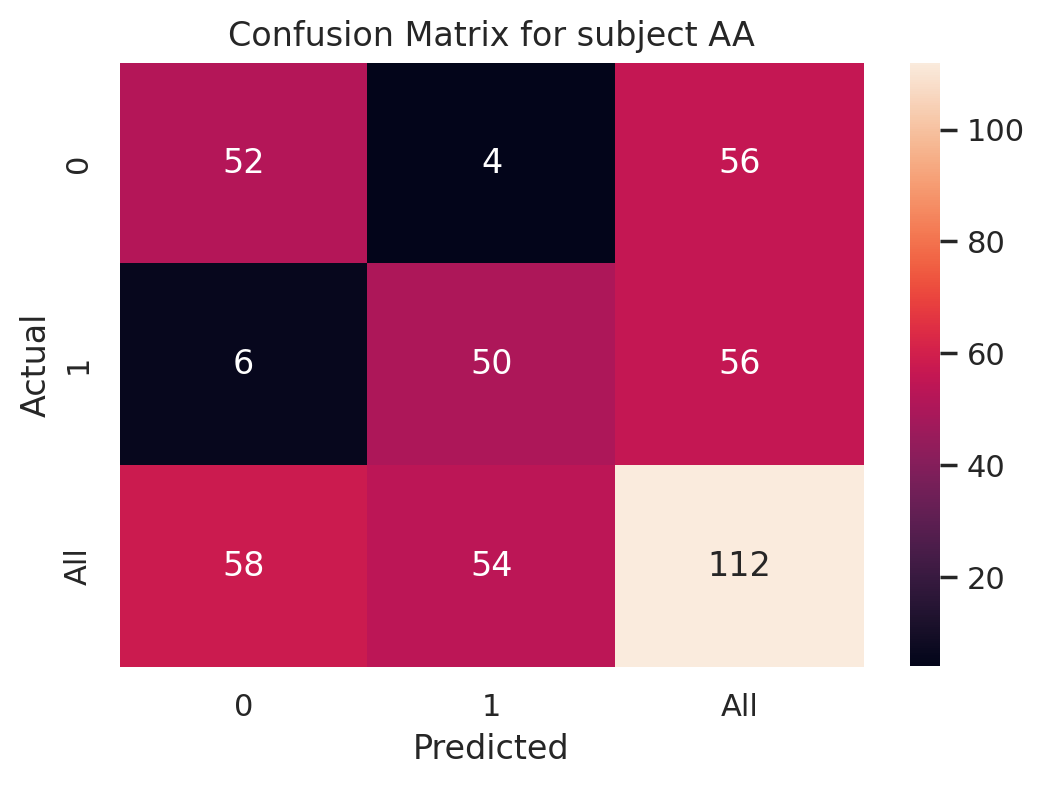

------------------------------------------------------------------------
   > Accuracy for "AL" test set : 94.64% 
   > f1 score for "AL" test set : 94.55% 
   > Precision score for "AL" test set : 96.3% 
   > Recall score for "AL" test set : 0.929 
   > AUC score for "AL" test set : 0.946 
------------------------------------------------------------------------


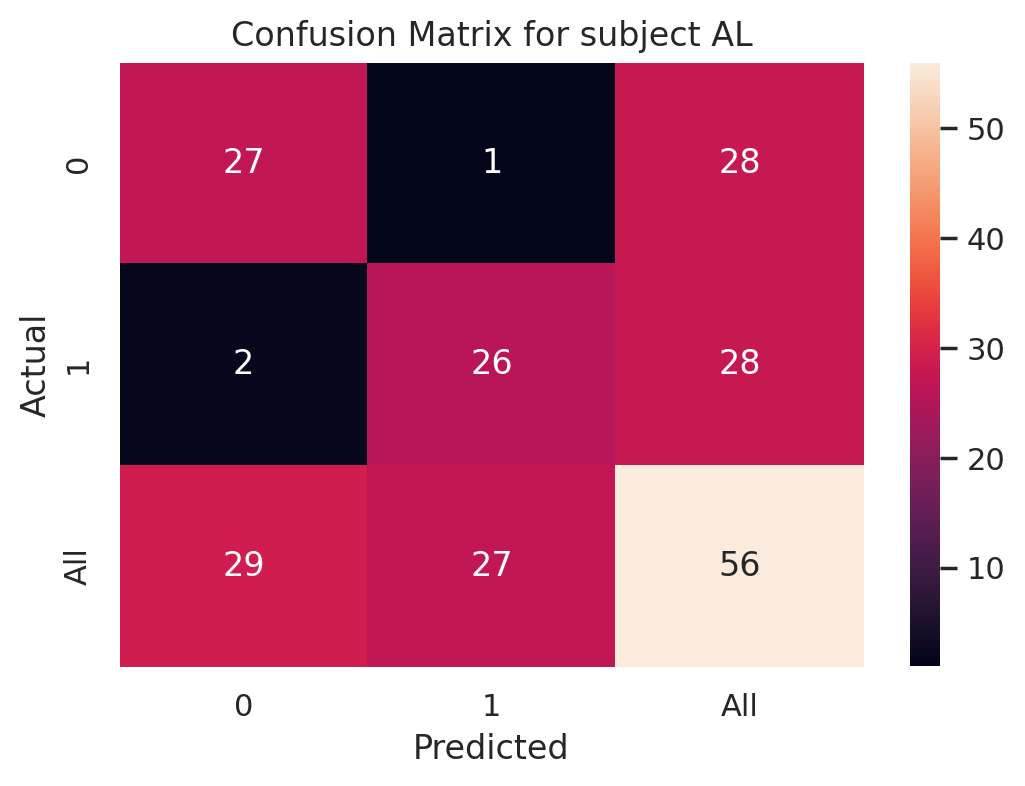

------------------------------------------------------------------------
   > Accuracy for "AV" test set : 87.76% 
   > f1 score for "AV" test set : 87.5% 
   > Precision score for "AV" test set : 89.36% 
   > Recall score for "AV" test set : 0.857 
   > AUC score for "AV" test set : 0.878 
------------------------------------------------------------------------


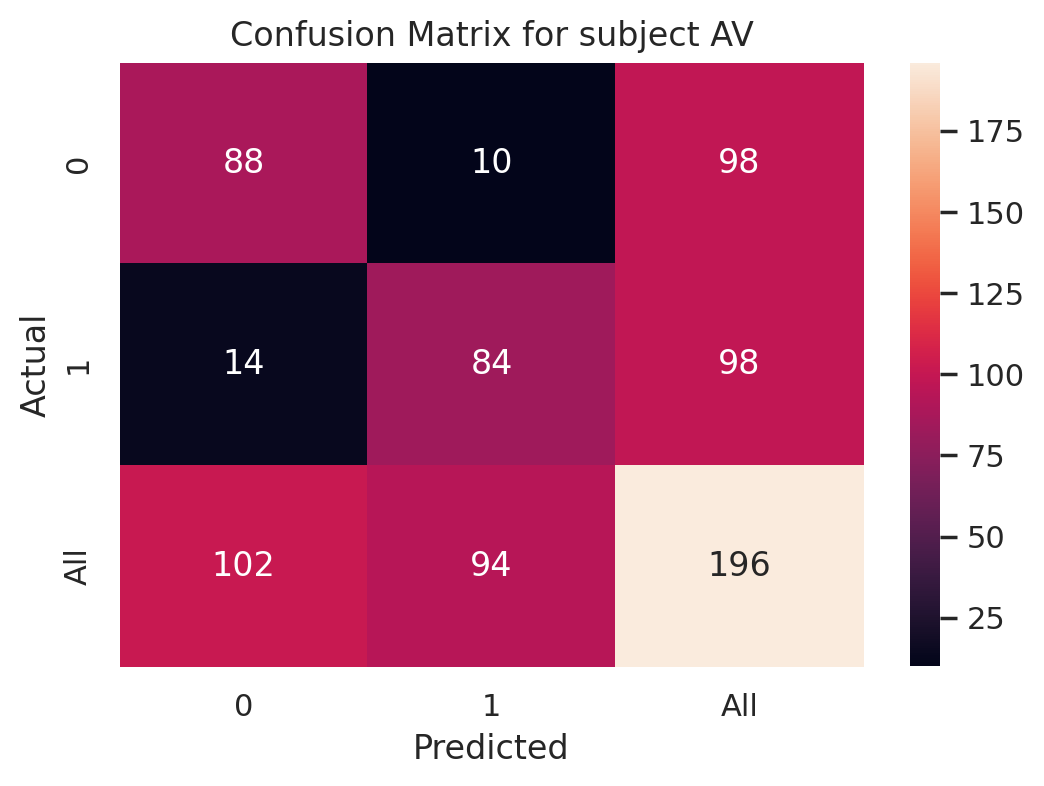

------------------------------------------------------------------------
   > Accuracy for "AW" test set : 92.86% 
   > f1 score for "AW" test set : 92.86% 
   > Precision score for "AW" test set : 92.86% 
   > Recall score for "AW" test set : 0.929 
   > AUC score for "AW" test set : 0.929 
------------------------------------------------------------------------


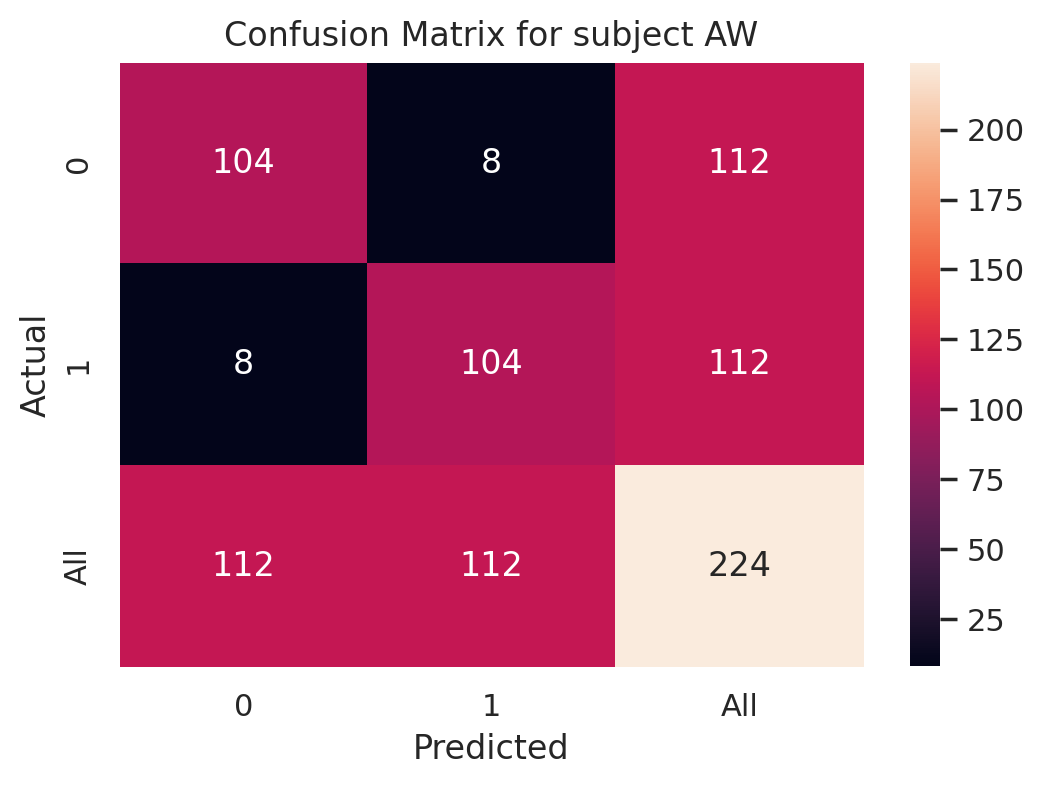

------------------------------------------------------------------------
   > Accuracy for "AY" test set : 93.65% 
   > f1 score for "AY" test set : 93.65% 
   > Precision score for "AY" test set : 93.65% 
   > Recall score for "AY" test set : 0.937 
   > AUC score for "AY" test set : 0.937 
------------------------------------------------------------------------


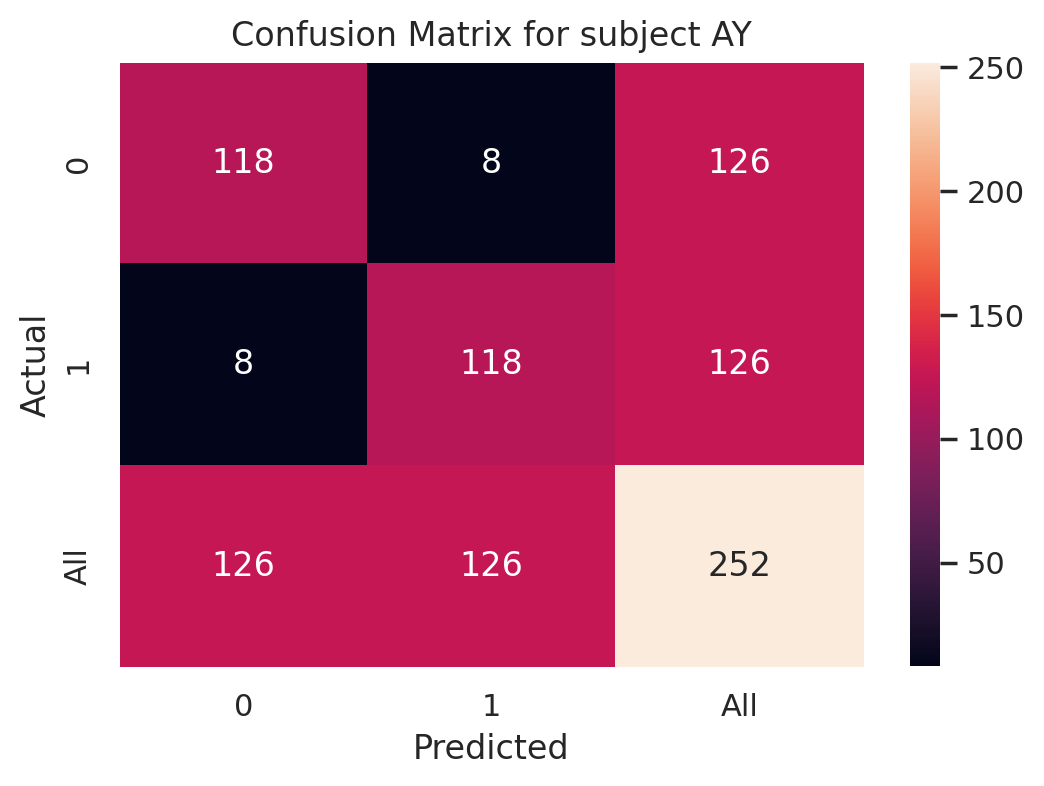


Average test sets accuracies: 92.0% (+- 0.0242)

Average test sets f1 score: 0.9189

Average test sets precision scores: 0.9295

Average test sets recall score: 0.9087

Average test sets AUCs: 0.92


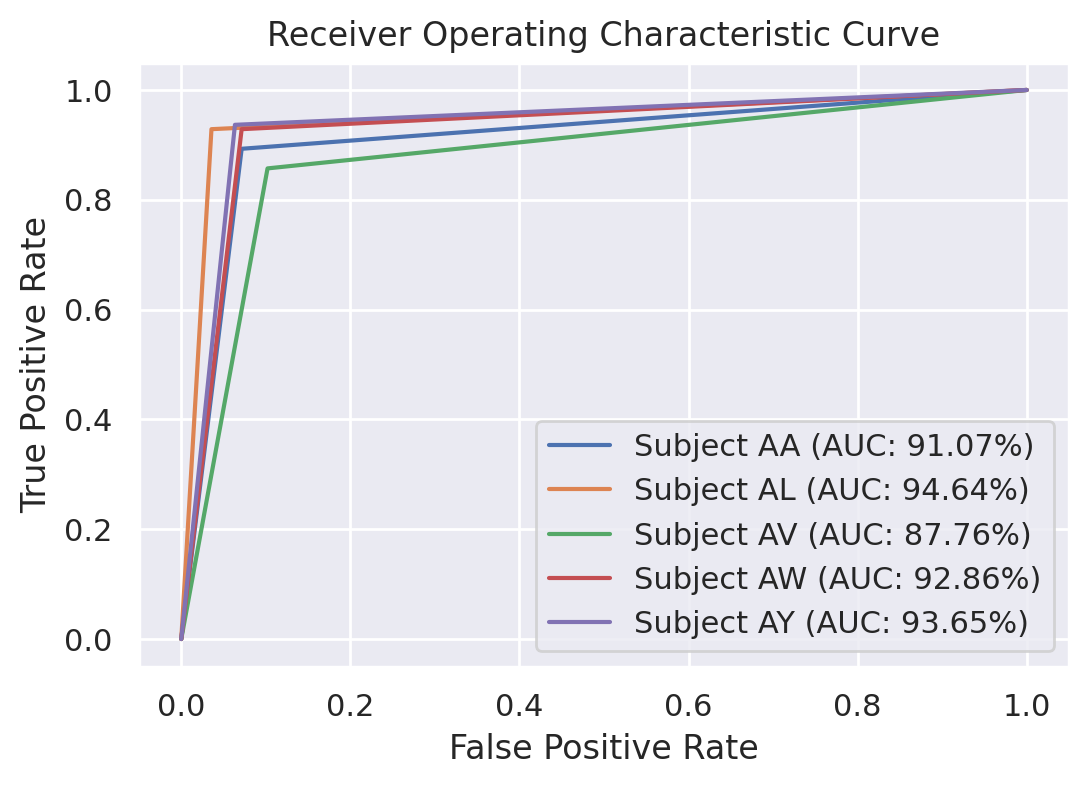

In [ ]:
Performance('SoftCLf model', SoftCLf,data)